In [1]:
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline


import time as t

In [2]:
import pandas as pd
import sys
import pybullet as p
from env_pybullet_gen3 import env_pybullet_kin_gen3



In [3]:
#To improve the velocity, run it on the GPU


#Create a experiment env
env = env_pybullet_kin_gen3(no_zeros = True,Excels_path_Okay_tcp_list = ["Tcp_Trajectori_19_1.xlsx","Tcp_Trajectori_39_1.xlsx","Tcp_Trajectori_59_1.xlsx"],time_step=0.02,home_angles = [-0.207226464676801,1.5689993219813,-1.01515387451347,-2.45271819663908,2.00795352004673,1.91098991659003,-0.831045149646278])
env.robot.visual_inspection = False

#Initially parameters of the urdf

#Make maxvels closer to the reality
#both have to be modified
env.max_vel = [168,151,128,94,210,48,189]
env.original_parameters_df ["max_vel"]=env.max_vel
print(env.original_parameters_df["max_vel"])
print(env.original_parameters_df)


print('observation space:', env.observation_space) #states, There is only 1 state constant
env.update_parameters_to_modify(["mass","max_vel","kp","ki","kd","force_x_one","Ixx","Iyy","Izz"])
#env.update_parameters_to_modify_base(["mass_base","Ixx_base","Iyy_base","Izz_base"])
print('action space:', env.action_space) #parameters, number of parameters choose to tune, continuous
print('original action:', env.action_original()) #parameters, number of parameters choose to tune, continuous




hola
../Simulation_Pybullet/models/urdf/JACO3_URDF_V11.urdf
Robot launched
hola
(7, 12)
(7, 17)
Base parameters mod    mass_base  Ixx_base  Iyy_base  Izz_base
0   1.697353  0.005787  0.005796  0.002735
Base parameters     mass_base  Ixx_base  Iyy_base  Izz_base
0   1.697353  0.005787  0.005796  0.002735
0    168
1    151
2    128
3     94
4    210
5     48
6    189
Name: max_vel, dtype: int64
       mass damping       Ixx       Iyy       Izz   kp   ki   kd  max_vel  \
0  1.377353       0  0.004801  0.004755  0.002283  0.1  0.0  0.0      168   
1  1.163667       0  0.008419  0.001920  0.008361  0.1  0.0  0.0      151   
2  1.163660       0  0.007545  0.007487  0.001921  0.1  0.0  0.0      128   
3  0.930287       0  0.006410  0.001380  0.006518  0.1  0.0  0.0       94   
4  0.678106       0  0.001680  0.001506  0.000826  0.1  0.0  0.0      210   
5  0.678106       0  0.001938  0.000827  0.001763  0.1  0.0  0.0       48   
6  0.500657       0  0.000775  0.000585  0.000975  0.1  0.0  0.0 

In [4]:
#Cross Entrophy Method, to choose the weights

# In my case where only 1 action,and that it's apply the parameters do another step doesn't change anything due to the state doesn't vary
# For this reason max_t and gama doesn't make sense, so I set them to max_t = 1 and gamma to 0
def cem_no_net(n_iterations=700, max_t=1, gamma=0.0, print_every=50, pop_size=env.action_space, elite_frac=10/(env.action_space*2), sigma=0.3,sigma_reduction_every_print = 0.65, per_one = True ):
    """PyTorch implementation of the cross-entropy method.
        
    Params
    ======
        n_iterations (int): maximum number of training iterations
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        pop_size (int): size of population at each iteration
        elite_frac (float): percentage of top performers to use in update
        sigma (float): standard deviation of additive noise
        per_one (boolean): to determine if the output is in per one or not
    """
    #Numbers of elements that you keep as the better ones
    n_elite=int(pop_size*elite_frac)
    
    #scores doble end queee , from iterations size * 0.1
    scores_deque = deque(maxlen=int(n_iterations*0.1))
    #intial scores empty
    scores = []
    #Save actions to see how they evolve
    best_actions = []
    #Select a seed to make the results the same every test, not depending on the seed
    np.random.seed(0)
    #Initial best weights, are from 0 to 1, it's good to be small the weights, but they should be different from 0.
    # small to avoid overfiting , different from 0 to update them
    
    if (per_one == True):
        best_weight = sigma*np.random.randn(env.action_space)
        original_action = np.array(env.action_original())
    else:
        best_weight = np.add(sigma*np.random.randn(env.action_space),env.action_original())

    #Each iteration, modify  + (from 0 to 1) the best weight randomly
    #Computes the reward with these weights
    #Sort the reward to get the best ones
    # Save the best weights
    # the Best weight it's the mean of the best one
    #compute the main reward of the main best rewards ones
    #this it's show to evalute how good its
    
    for i_iteration in range(1, n_iterations+1):
        
        #Generate new population weights, as a mutation of the best weight to test them
        weights_pop = [best_weight + (sigma*np.random.randn(env.action_space)) for i in range(pop_size)]
        
        #Compute the parameters and obtain the rewards for each of them
        #print("iteration "+str(i_iteration))
        if (per_one == True):
            rewards=[]
            for weights in weights_pop:
                #print("New weights")
                #print(weights)
                #t.sleep(1000)
                action=np.add(np.multiply(weights,original_action),original_action)
                rewards.append( env.step_tcp_rishabh_joints_offset(action,Experiment_time=1.22) )
            rewards = np.array(rewards)
        else:
            rewards=[]
            for weights in weights_pop:
                rewards.append(env.step_tcp_rishabh_joints_offset(weights,Experiment_time=1.22) )
            rewards = np.array(rewards)
        print("rewards" + str(i_iteration))
        print(rewards)
        #print("\n")
        
        #Sort the rewards to obtain the best ones
        elite_idxs = rewards.argsort()[-n_elite:]
        elite_weights = [weights_pop[i] for i in elite_idxs]
        
        #Set the best weight as the mean of the best ones 
       
        best_weight = np.array(elite_weights).mean(axis=0)
        
        #Get the reward with this new weight
        
        if (per_one == True):
            action = np.add(np.multiply(best_weight,original_action),original_action)
            #print("action vel")
            #print(action[8])
            #print("action kp")
            #print(action[15])
            #time.sleep(1000)
            best_actions.append(action)
            reward = env.step_tcp_rishabh_joints_offset(action,Experiment_time=1.22)
            print("reward")
            print(reward)
            print("\n")
        else:
            best_actions.append(best_weight)
            reward = env.step_tcp_rishabh_joints_offset(best_weight,Experiment_time=1.22)
        scores_deque.append(reward)
        scores.append(reward)
        
        #save the check point
        env.save_parameters("./Parameters_train_tcp_euc_rishabh_joint_offset_base.xlsx")
        
        if i_iteration % print_every == 0:
            sigma = sigma * sigma_reduction_every_print
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))

        if np.mean(scores_deque)>=0.0:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-n_iterations*0.1, np.mean(scores_deque)))
            break
    return scores,best_actions


rewards1
[-0.27936501 -0.2846864  -0.28044654 -0.26291896 -0.26034644 -0.32023998
 -0.2825059  -0.25316399 -0.26726246 -0.28581309 -0.31244226 -0.27610082
 -0.28278366 -0.29029627 -0.27713504 -0.29616681 -0.29754757 -0.29088402
 -0.3107326  -0.2747952  -0.2719368  -0.26796446 -0.28825991 -0.27542736
 -0.25626125 -0.27009424 -0.31565538 -0.30055328 -0.28447061 -0.32568134
 -0.27735091 -0.25956637 -0.30913841 -0.29528543 -0.27548812 -0.27692938
 -0.27913348 -0.27830531 -0.25707705 -0.271676   -0.28754438 -0.27100842
 -0.30690236 -0.27441705 -0.28375415 -0.31234948 -0.27265269 -0.26359126
 -0.29088052 -0.27092653 -0.27673151 -0.27642993 -0.27756919 -0.28834126
 -0.2757974  -0.32027178 -0.28321771 -0.26436665 -0.37270655 -0.2862759
 -0.30125376 -0.27828039 -0.29295488]
reward
-0.25447533893378355


maximum iterations reach
maximum iterations reach
rewards2
[-0.24548497 -0.2899956  -0.2744959  -0.2608684  -0.24834783 -0.24577996
 -0.25919379 -0.26305037 -0.2720018  -0.27464908 -0.27267199 -

rewards12
[-0.13611376 -0.14528763 -0.17142821 -0.16982457 -0.1608103  -0.16053387
 -0.17643628 -0.15966099 -0.16162013 -0.1449539  -0.17223804 -0.15856232
 -0.16593703 -0.15663785 -0.13512994 -0.14108236 -0.14823111 -0.16644341
 -0.16836994 -0.15998614 -0.15161252 -0.76180986 -0.15033014 -0.17512982
 -0.23988783 -0.16458529 -0.20884889 -0.17105226 -0.13087057 -0.15076192
 -0.18914001 -0.18669599 -0.14337444 -0.15326324 -0.15192728 -0.14667477
 -0.14576668 -0.19085543 -0.1339417  -0.14614496 -0.18649749 -0.15190326
 -0.13888962 -0.14560752 -0.14725518 -0.14871317 -0.15856786 -0.30888298
 -0.15529698 -0.15400092 -0.1751337  -0.13617034 -0.15108955 -0.14636568
 -0.13802327 -0.1689051  -0.14390075 -0.15009357 -0.21826746 -0.14606496
 -0.17017036 -0.14926285 -0.15024531]
reward
-0.12961651728846935


maximum iterations reach
maximum iterations reach
rewards13
[-0.1306031  -0.1414707  -0.13743124 -0.16923664 -0.14826938 -0.14936604
 -0.15051013 -0.14176821 -0.18171322 -0.16701624 -0.1790580

maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
rewards18
[-0.1210731  -0.10712172 -0.1161794  -0.12145652 -0.119615   -0.10329506
 -0.12103842 -0.13279872 -0.12073733 -0.11260477 -0.14305127 -0.12464343
 -0.11040109 -0.12919732 -0.1071703  -0.13065641 -0.12311997 -0.12834165
 -0.11920962 -0.11141187 -0.11884569 -0.13497827 -0.13971114 -0.13146962
 -0.13841011 -0.12660075 -0.16666362 -0.10964358 -0.12899961 -0.15042316
 -0.13018628 -0.17820575 -0.11859446 -0.11269158 -0.11832237 -0.10698701
 -0.115517   -0.13513879 -0.15198454 -0.1364514  -0.10951399 -0.12410595
 -0.15983535 -0.11831763 -0.19958523 -0.38536983 -0.18641526 -0.11292977
 -0.22

rewards24
[-0.13461161 -0.10875159 -0.09757413 -0.10341781 -0.19215014 -0.12765903
 -0.10055326 -0.72230034 -0.47525445 -0.37938814 -0.16720405 -0.11201609
 -0.4353589  -0.09695251 -0.08787758 -0.1227578  -0.12589411 -0.4385603
 -0.26819073 -0.83009706 -0.11080539 -0.12812715 -0.74380287 -0.45152072
 -0.15984896 -0.10151614 -0.13908293 -0.29146134 -0.08926309 -0.10166547
 -0.15521065 -0.09692838 -0.23588533 -0.54101909 -0.10760397 -0.43853291
 -0.10400995 -0.1107139  -0.12962349 -0.09949237 -0.10151267 -0.11749381
 -0.10752319 -0.14259859 -0.1030519  -0.12407315 -0.11095012 -0.09994966
 -0.11026908 -0.22860113 -0.09583034 -0.10117037 -0.11490832 -0.10392277
 -0.15784322 -0.10987617 -0.45880019 -0.14823817 -0.11881391 -0.11812665
 -0.0907962  -0.10824027 -0.69848895]
reward
-0.08311965689929614


rewards25
[-0.1095952  -0.13896719 -0.08625059 -0.11535395 -0.11404878 -0.11906282
 -0.17716541 -0.12969984 -0.11630402 -0.10538879 -0.08903746 -0.2204472
 -0.45563342 -0.10262652 -0.09654017 -

rewards35
[-0.11485205 -0.1136554  -0.11243657 -0.07871845 -0.09972689 -0.09408092
 -0.09828116 -0.13364123 -0.08442572 -0.12626188 -0.09608916 -0.10919189
 -0.11256575 -0.12004018 -0.09892023 -0.09449901 -0.08844922 -0.1610062
 -0.09968284 -0.09490895 -0.18403502 -0.14023212 -0.10492641 -0.13874476
 -0.10126673 -0.11591188 -0.17304823 -0.12920751 -0.11743908 -0.07906849
 -0.11208933 -0.08489142 -0.08539422 -0.1012355  -0.12195437 -0.15631448
 -0.1188599  -0.10952802 -0.08825329 -0.08677554 -0.08185069 -0.11604793
 -0.10752058 -0.08599385 -0.11273065 -0.08813918 -0.08373568 -0.11479184
 -0.09183495 -0.40853911 -0.09539775 -0.14072873 -0.10068694 -0.09625887
 -0.14875009 -0.09610655 -0.15264897 -0.08915809 -0.11193971 -0.12422093
 -0.09759364 -0.08936159 -0.12169157]
reward
-0.07634412128730543


rewards36
[-0.09177036 -0.08496426 -0.08988329 -0.08827556 -0.09880809 -0.10619546
 -0.08985167 -0.10310281 -0.11360868 -0.08581643 -0.08029568 -0.08508608
 -0.0883069  -0.0901868  -0.49153063 

rewards46
[-0.10814929 -0.09657743 -0.0859028  -0.08954852 -0.09176295 -0.09244092
 -0.08955718 -0.10279152 -0.1268115  -0.12224446 -0.105485   -0.11385906
 -0.12497085 -0.12633189 -0.11549929 -0.10957997 -0.07790424 -0.09146914
 -0.11065991 -0.12005982 -0.07104514 -0.09483181 -0.17693851 -0.07764434
 -0.08702257 -0.10699976 -0.08663539 -0.1320161  -0.11015806 -0.08945509
 -0.08474227 -0.11614216 -0.09224702 -0.1142494  -0.08831782 -0.09549468
 -0.0964269  -0.08789296 -0.09727972 -0.10603613 -0.11021337 -0.08708813
 -0.09891551 -0.14073358 -0.10245733 -0.12655266 -0.12834264 -0.10173779
 -0.12268673 -0.09761731 -0.12486231 -0.10405352 -0.11206474 -0.18574001
 -0.08699096 -0.11329169 -0.09636137 -0.08965909 -0.11397133 -0.12222113
 -0.10198948 -0.11568504 -0.0908742 ]
reward
-0.07466015057233727


maximum iterations reach
maximum iterations reach
maximum iterations reach
rewards47
[-0.10865934 -0.12118801 -0.1352008  -0.08898912 -0.14708517 -0.08461569
 -0.10795759 -0.08301143 -0.086214

rewards56
[-0.06867785 -0.08894949 -0.0875433  -0.07217407 -0.08338712 -0.09504597
 -0.06884991 -0.07883746 -0.07399787 -0.08066482 -0.06771632 -0.06874594
 -0.07868899 -0.06874504 -0.07214134 -0.09736724 -0.07071705 -0.07713316
 -0.07416785 -0.08201736 -0.07493192 -0.09225158 -0.07894718 -0.08750056
 -0.08376392 -0.06384418 -0.08639675 -0.08207384 -0.07475949 -0.07061917
 -0.08336689 -0.10234445 -0.07443023 -0.08675758 -0.07401671 -0.06670255
 -0.07007969 -0.11619096 -0.06506161 -0.07794191 -0.07404753 -0.07983119
 -0.1000724  -0.06663636 -0.08016128 -0.09577752 -0.07367144 -0.06451287
 -0.07062846 -0.0793659  -0.08378849 -0.07520367 -0.09278481 -0.07330574
 -0.08572485 -0.07369922 -0.07725319 -0.09452309 -0.0885177  -0.07870817
 -0.07429993 -0.06907038 -0.07415053]
reward
-0.06289860870100213


rewards57
[-0.06842353 -0.0866846  -0.07972795 -0.09334509 -0.06814706 -0.08653701
 -0.09649448 -0.08365343 -0.07669951 -0.07898534 -0.07009832 -0.0715339
 -0.07632548 -0.08015212 -0.07716233 

rewards66
[-0.14480405 -0.06640518 -0.11581634 -0.10185057 -0.08640722 -0.06937276
 -0.08169788 -0.07607745 -0.06564676 -0.09483795 -0.08671942 -0.06574299
 -0.08269745 -0.06621821 -0.07083244 -0.0695528  -0.11517602 -0.0665447
 -0.07141757 -0.07201667 -0.07078994 -0.07171373 -0.06734508 -0.08272085
 -0.07064747 -0.08239295 -0.11336665 -0.09983951 -0.11508901 -0.0718133
 -0.19331602 -0.07322442 -0.07236044 -0.0673996  -0.06838999 -0.06801771
 -0.06685574 -0.07958617 -0.07426081 -0.10901985 -0.08681294 -0.07393428
 -0.08800512 -0.06390675 -0.06728715 -0.08278685 -0.08097867 -0.07463248
 -0.09075968 -0.06618713 -0.5865197  -0.0740291  -0.09237357 -0.09238517
 -0.07001472 -0.08143159 -0.06433282 -0.10512184 -0.08661362 -0.15994358
 -0.06582979 -0.0918654  -0.07806733]
reward
-0.0584257769865851


rewards67
[-0.09288448 -0.07787945 -0.06756782 -0.09364111 -0.09298127 -0.07674528
 -0.07529525 -0.07181827 -0.12276969 -0.07361343 -0.07538743 -0.10870933
 -0.06010188 -0.07547819 -0.09248668 -0

maximum iterations reach
maximum iterations reach
maximum iterations reach
rewards77
[-0.08692532 -0.07904452 -0.10562454 -0.07383527 -0.06198798 -0.07209833
 -0.20296862 -0.06823411 -0.07250876 -0.07290134 -0.09421139 -0.08272351
 -0.07997936 -0.07423802 -0.07681547 -0.06797252 -0.0636644  -0.09248169
 -0.13049159 -0.06483595 -0.1000489  -0.11132568 -0.53835573 -0.07349242
 -0.07541448 -0.07807512 -0.07200825 -0.0850081  -0.08278027 -0.08805839
 -0.0872412  -0.06950669 -0.0837838  -0.08025673 -0.09848256 -0.08156555
 -0.07381004 -0.08255447 -0.07260039 -0.08970586 -0.0707467  -0.06651824
 -0.06842907 -0.09899745 -0.06945673 -0.08689612 -0.05787822 -0.06368853
 -0.0782076  -0.06806268 -0.06356343 -0.07512539 -0.06072041 -0.09040708
 -0.06898659 -0.08091146 -0.06264755 -0.11620009 -0.06265056 -0.07956571
 -0.13499582 -0.07708106 -0.06340964]
reward
-0.057504208075248524


rewards78
[-0.07095493 -0.06809597 -0.05923229 -0.08278984 -0.06598486 -0.06535652
 -0.0884904  -0.08696627 -0.06373

rewards88
[-0.06702457 -0.09106776 -0.100155   -0.07815009 -0.06143121 -0.0817066
 -0.06143923 -0.07579073 -0.08633228 -0.06155633 -0.07264717 -0.0726137
 -0.08407986 -0.07628519 -0.07908578 -0.06297558 -0.08643494 -0.08654833
 -0.06851753 -0.06831931 -0.06626526 -0.06124604 -0.05671603 -0.07087727
 -0.06436127 -0.07267929 -0.07664525 -0.08392655 -0.06696601 -0.07040232
 -0.05331133 -0.07647727 -0.06429768 -0.06327249 -0.10397327 -0.10689894
 -0.07555007 -0.07294559 -0.09538945 -0.07197474 -0.08644337 -0.06778538
 -0.06910095 -0.09442136 -0.06825177 -0.09202724 -0.06850784 -0.09193982
 -0.07886257 -0.08567112 -0.06838304 -0.06062577 -0.06869288 -0.08927718
 -0.08653354 -0.06907435 -0.06620191 -0.06266652 -0.09108239 -0.07813594
 -0.06654868 -0.0725225  -0.10022234]
reward
-0.05661743204755219


rewards89
[-0.07844633 -0.07038639 -0.06853764 -0.08886426 -0.06417645 -0.0688051
 -0.08059375 -0.07116225 -0.06482909 -0.08323792 -0.06745348 -0.07947752
 -0.07201155 -0.06744551 -0.06822829 -0

rewards99
[-0.08667025 -0.06496976 -0.07041    -0.05944429 -0.12850079 -0.06466658
 -0.05758044 -0.07208855 -0.06883012 -0.07670934 -0.06739389 -0.08236255
 -0.07326221 -0.07692331 -0.07505453 -0.09308484 -0.09046828 -0.06785304
 -0.07828976 -0.08404587 -0.08732377 -0.09096928 -0.06420871 -0.05855663
 -0.08880735 -0.06364619 -0.08895263 -0.06193305 -0.0718482  -0.06069422
 -0.07241158 -0.06619056 -0.06438491 -0.07140275 -0.08392535 -0.07545739
 -0.09879946 -0.11210585 -0.07229597 -0.08452543 -0.07126505 -0.06392037
 -0.08105933 -0.09344028 -0.08527439 -0.06327892 -0.09066906 -0.0734581
 -0.06523251 -0.08235808 -0.06826694 -0.06845493 -0.06243084 -0.06531782
 -0.06952135 -0.06235323 -0.08571503 -0.07715261 -0.06426254 -0.06788819
 -0.05910298 -0.0726203  -0.06740033]
reward
-0.05383677332967827


rewards100
[-0.06331535 -0.08742817 -0.06016283 -0.06515502 -0.06932423 -0.07281736
 -0.06246596 -0.06568786 -0.06382354 -0.07013787 -0.07150258 -0.0695923
 -0.07438815 -0.07025799 -0.07340004 

rewards109
[-0.06076514 -0.05532387 -0.05727336 -0.06203429 -0.06016654 -0.06533329
 -0.06172237 -0.05689811 -0.07984648 -0.05969479 -0.05410146 -0.05768569
 -0.06979238 -0.05770676 -0.06023879 -0.06277973 -0.0859007  -0.07021734
 -0.0748478  -0.05944231 -0.06125542 -0.07440868 -0.05353528 -0.06021566
 -0.054396   -0.07200452 -0.06247326 -0.05449684 -0.05758216 -0.06523758
 -0.05129473 -0.06170664 -0.05721721 -0.06281986 -0.06357082 -0.06441692
 -0.06918023 -0.07592492 -0.06454681 -0.06014278 -0.06465138 -0.08034942
 -0.0556366  -0.06012742 -0.06156305 -0.05681756 -0.09174309 -0.07125402
 -0.05602572 -0.05328898 -0.05074684 -0.07496211 -0.05491948 -0.06511521
 -0.05890314 -0.06461081 -0.06032156 -0.07264663 -0.0667063  -0.05861341
 -0.06882669 -0.05834752 -0.0597544 ]
reward
-0.050014525685720145


rewards110
[-0.0568413  -0.06218849 -0.06016477 -0.06035297 -0.05651865 -0.06320045
 -0.06843384 -0.06186058 -0.05819593 -0.06185312 -0.07048254 -0.05826683
 -0.05937802 -0.05422592 -0.05202

rewards120
[-0.05257047 -0.05872958 -0.05510489 -0.05607713 -0.06757972 -0.05492344
 -0.05223525 -0.06591152 -0.05848927 -0.05968296 -0.05535155 -0.06164901
 -0.05888017 -0.0610369  -0.06647086 -0.05940201 -0.08063483 -0.06107309
 -0.05726226 -0.06853889 -0.06712094 -0.06212623 -0.05860227 -0.0730103
 -0.05647105 -0.05830842 -0.06337356 -0.0604791  -0.05492537 -0.06135554
 -0.05231191 -0.06550581 -0.05981402 -0.07168809 -0.07062925 -0.06220268
 -0.05402533 -0.05961212 -0.05367421 -0.06039112 -0.06231007 -0.06411227
 -0.0719846  -0.08036912 -0.05578851 -0.05511697 -0.05269552 -0.0607093
 -0.06173346 -0.05577947 -0.05616845 -0.05625974 -0.06166375 -0.05184363
 -0.06367261 -0.06000852 -0.06315147 -0.09092335 -0.05424456 -0.08010625
 -0.06485606 -0.05961649 -0.07982079]
reward
-0.04981637339349304


rewards121
[-0.06876039 -0.05815804 -0.06017954 -0.05398963 -0.05603593 -0.05849538
 -0.06641039 -0.06104192 -0.0586456  -0.05974355 -0.07003249 -0.06618094
 -0.05165158 -0.05436281 -0.08345732

rewards131
[-0.06755775 -0.0597156  -0.06086254 -0.05608297 -0.05715529 -0.06220833
 -0.05972106 -0.05875264 -0.05470032 -0.05629075 -0.054547   -0.0554961
 -0.06472644 -0.06189997 -0.07648014 -0.06797182 -0.06347524 -0.05650787
 -0.05992699 -0.0572006  -0.05569797 -0.0774288  -0.05291848 -0.0658125
 -0.06015913 -0.058167   -0.06631022 -0.10274052 -0.06101303 -0.06915426
 -0.06790149 -0.05850385 -0.06806085 -0.10595394 -0.06462145 -0.07767082
 -0.05821234 -0.06733959 -0.0574289  -0.07174365 -0.06249735 -0.05361283
 -0.0508868  -0.05836489 -0.07125758 -0.06292715 -0.05264924 -0.06244998
 -0.06267429 -0.06691437 -0.06373755 -0.06249725 -0.06291169 -0.05538819
 -0.05495535 -0.05867036 -0.05545526 -0.07179833 -0.07718982 -0.06584652
 -0.05148644 -0.05869192 -0.06882655]
reward
-0.048989371101868025


rewards132
[-0.05868626 -0.06501808 -0.10187744 -0.05808517 -0.06122959 -0.06721389
 -0.05690497 -0.06267157 -0.08782661 -0.05227162 -0.06299801 -0.05747469
 -0.06280988 -0.06285026 -0.0565620

rewards142
[-0.05347646 -0.06381671 -0.05561456 -0.05770305 -0.05985743 -0.06943017
 -0.0565342  -0.05477747 -0.05490351 -0.09150078 -0.08869099 -0.06461777
 -0.05406791 -0.06208652 -0.11783937 -0.07369341 -0.06499709 -0.07359439
 -0.05816706 -0.05413627 -0.09405161 -0.09504372 -0.05326537 -0.06039556
 -0.07115692 -0.05733398 -0.06429731 -0.07041065 -0.0663563  -0.0572994
 -0.06320074 -0.08964392 -0.05581656 -0.14966458 -0.05992119 -0.06590437
 -0.08049345 -0.05142717 -0.05735784 -0.06993792 -0.05581596 -0.05818594
 -0.0655995  -0.07681174 -0.06098662 -0.06388776 -0.06584825 -0.08253158
 -0.07890648 -0.07517125 -0.06048775 -0.06586451 -0.06503443 -0.05950028
 -0.05812884 -0.05055054 -0.0545421  -0.06323192 -0.08196139 -0.06818682
 -0.05462288 -0.05183064 -0.05582415]
reward
-0.049340991534175344


rewards143
[-0.05552673 -0.05914487 -0.05137724 -0.06108021 -0.06226811 -0.0588229
 -0.0550817  -0.06074069 -0.05905066 -0.05152499 -0.05962712 -0.0733778
 -0.0570566  -0.05684366 -0.06048119

rewards153
[-0.05237304 -0.05317923 -0.05512122 -0.05402748 -0.0644913  -0.0494373
 -0.05303001 -0.07014924 -0.05412239 -0.05348176 -0.06172346 -0.05520492
 -0.05266661 -0.05000268 -0.06867733 -0.05128836 -0.05534602 -0.05561917
 -0.0602605  -0.04975097 -0.05316047 -0.0666306  -0.06053722 -0.05169754
 -0.05233722 -0.05805763 -0.05545703 -0.0491234  -0.05736293 -0.05214308
 -0.05398103 -0.06272843 -0.05417336 -0.05244619 -0.05168172 -0.05118136
 -0.05343164 -0.05281572 -0.06035056 -0.0528347  -0.05357541 -0.05384176
 -0.04946734 -0.05127104 -0.05998505 -0.05179019 -0.05088985 -0.05270541
 -0.05438043 -0.0519366  -0.0499573  -0.0583676  -0.06211973 -0.05174342
 -0.05269872 -0.05468708 -0.0580991  -0.05082614 -0.0504854  -0.05440905
 -0.06416819 -0.04966525 -0.05046154]
reward
-0.048057378772909165


rewards154
[-0.05348374 -0.05035904 -0.0537716  -0.05472533 -0.06652601 -0.05222468
 -0.05101322 -0.05652532 -0.05114397 -0.0542436  -0.05382407 -0.06761765
 -0.05862043 -0.07444648 -0.062492

rewards164
[-0.05090216 -0.06389108 -0.051457   -0.04941014 -0.05337015 -0.0618048
 -0.05524058 -0.05779676 -0.05240437 -0.05281297 -0.04950941 -0.0587958
 -0.05763716 -0.05166544 -0.04810584 -0.05032941 -0.0535329  -0.05704616
 -0.05709225 -0.05806243 -0.05593091 -0.05690727 -0.04857994 -0.05123782
 -0.05568857 -0.04960134 -0.05352347 -0.05280432 -0.04955162 -0.05392516
 -0.04848054 -0.05161003 -0.05199655 -0.05331376 -0.05212725 -0.05296776
 -0.0508258  -0.05839646 -0.05093584 -0.05199827 -0.0519166  -0.05667189
 -0.05155698 -0.05645232 -0.04881025 -0.05429279 -0.0542137  -0.04984574
 -0.0586955  -0.05602637 -0.05625612 -0.05105907 -0.05158727 -0.05014639
 -0.05268697 -0.05243647 -0.05163611 -0.04919942 -0.06103451 -0.05757569
 -0.05459206 -0.05832377 -0.05491913]
reward
-0.04767106663415238


rewards165
[-0.0541129  -0.05951052 -0.0511475  -0.07994842 -0.05699612 -0.05202186
 -0.05273133 -0.06670737 -0.0563026  -0.05570643 -0.05303077 -0.05770934
 -0.05324691 -0.05033889 -0.05721153

rewards175
[-0.05541282 -0.050125   -0.05827284 -0.05094442 -0.05219033 -0.05988487
 -0.05819638 -0.05146398 -0.05326339 -0.05170411 -0.05309968 -0.05024688
 -0.04920345 -0.05376066 -0.05124149 -0.06768812 -0.04923979 -0.05024429
 -0.04895507 -0.06618275 -0.05301508 -0.05554985 -0.05759546 -0.05525441
 -0.06903129 -0.05437898 -0.06985294 -0.06583061 -0.05738814 -0.06237352
 -0.04959605 -0.05929791 -0.05092798 -0.04943474 -0.05486487 -0.05495934
 -0.06128375 -0.05794254 -0.05101172 -0.05166461 -0.05026483 -0.04962531
 -0.0498659  -0.05528791 -0.05366608 -0.05183871 -0.05390453 -0.05781281
 -0.05244009 -0.06230508 -0.05469479 -0.05768232 -0.05161426 -0.05284934
 -0.0539503  -0.05193295 -0.05213868 -0.05186093 -0.05438767 -0.04943582
 -0.05482194 -0.05894428 -0.05607899]
reward
-0.0481364609489352


rewards176
[-0.05054559 -0.0611143  -0.06412543 -0.05843278 -0.05822415 -0.05584915
 -0.0538742  -0.05356433 -0.05802807 -0.05376271 -0.05033973 -0.0556495
 -0.07156126 -0.05371974 -0.05277683

rewards186
[-0.0501697  -0.05427081 -0.05059834 -0.05141193 -0.05333233 -0.05452084
 -0.05007908 -0.05258869 -0.05600196 -0.06010012 -0.05511478 -0.05590332
 -0.05558974 -0.05144211 -0.05200191 -0.05289857 -0.05574239 -0.04895082
 -0.05015154 -0.05240742 -0.05618291 -0.05479846 -0.05331165 -0.05189484
 -0.05012426 -0.0525617  -0.05707073 -0.06230096 -0.0536815  -0.05808945
 -0.05340005 -0.0494394  -0.05345414 -0.05784878 -0.05912023 -0.05800154
 -0.05513263 -0.05554643 -0.04943581 -0.05294717 -0.05336626 -0.05177189
 -0.05221183 -0.0503309  -0.05285627 -0.05508759 -0.06094107 -0.05033466
 -0.04852166 -0.05709291 -0.04846627 -0.05107403 -0.05601076 -0.05062831
 -0.04951471 -0.05238964 -0.05392087 -0.05523009 -0.05399862 -0.05400502
 -0.05227581 -0.04950108 -0.05557253]
reward
-0.046691179318854394


rewards187
[-0.05623692 -0.0552517  -0.04998038 -0.05204673 -0.05273104 -0.05792463
 -0.0514906  -0.05469526 -0.05466382 -0.05663644 -0.05403933 -0.0577734
 -0.05061054 -0.05107988 -0.051400

rewards197
[-0.05263145 -0.05639639 -0.05518417 -0.04988535 -0.0515171  -0.04967249
 -0.05191396 -0.08445089 -0.05432881 -0.05444533 -0.05837481 -0.05608842
 -0.05152479 -0.06781551 -0.05724935 -0.04999393 -0.05333887 -0.06069217
 -0.51644257 -0.44080511 -0.0498474  -0.05333023 -0.05127723 -0.05638666
 -0.05328591 -0.05085212 -0.05295345 -0.05595343 -0.05036954 -0.05400428
 -0.0495083  -0.05322801 -0.05383698 -0.05260436 -0.05289707 -0.04912902
 -0.05126593 -0.31688794 -0.05667441 -0.05039681 -0.05174828 -0.05304347
 -0.05430188 -0.05535819 -0.05340576 -0.05021853 -0.0530013  -0.05245989
 -0.05154693 -0.05801346 -0.48524854 -0.38950519 -0.43540017 -0.05192687
 -0.05360103 -0.17920032 -0.05576681 -0.05049618 -0.05872616 -0.050368
 -0.05910976 -0.05034465 -0.05492089]
reward
-0.047811755650159965


rewards198
[-0.0521392  -0.05221446 -0.04906792 -0.04811619 -0.05484905 -0.05231651
 -0.05164844 -0.0540664  -0.05413375 -0.05986674 -0.05501303 -0.05866302
 -0.04829728 -0.05319158 -0.0700416

rewards208
[-0.05250191 -0.04979449 -0.05206693 -0.05022323 -0.0484142  -0.05185806
 -0.05108254 -0.05025676 -0.05451717 -0.05268298 -0.04950203 -0.04997737
 -0.04878463 -0.05040055 -0.06382999 -0.05301371 -0.05118668 -0.0519341
 -0.04872824 -0.04971151 -0.05715652 -0.04945075 -0.05008815 -0.04866217
 -0.04873589 -0.05808957 -0.04935944 -0.05099552 -0.05152102 -0.05494927
 -0.05003974 -0.05365572 -0.04967602 -0.04756944 -0.05174445 -0.04791405
 -0.05608753 -0.05069071 -0.05130467 -0.05574742 -0.05302189 -0.05978915
 -0.06141827 -0.05435732 -0.0517415  -0.04745203 -0.04878566 -0.06057967
 -0.04700332 -0.05676357 -0.04692891 -0.05050207 -0.0503184  -0.04979567
 -0.05244987 -0.04987155 -0.04907171 -0.04976063 -0.05100091 -0.0573745
 -0.04764334 -0.04929305 -0.04777936]
reward
-0.0466924466527149


rewards209
[-0.04783848 -0.05053447 -0.04998068 -0.05211209 -0.05050202 -0.04908306
 -0.05293921 -0.05279641 -0.04936765 -0.05345636 -0.05145335 -0.04839514
 -0.04883828 -0.04788679 -0.05117369 

rewards219
[-0.04780664 -0.05101366 -0.05207091 -0.05420176 -0.04799065 -0.05598313
 -0.05051352 -0.05184222 -0.05386742 -0.05410573 -0.05596179 -0.04887822
 -0.04817837 -0.04913856 -0.05277958 -0.04925104 -0.05160568 -0.05662781
 -0.04971485 -0.05760694 -0.050091   -0.04908815 -0.05195804 -0.05460356
 -0.04993126 -0.05163911 -0.04838433 -0.04907949 -0.04968192 -0.05332777
 -0.04839055 -0.04995268 -0.04993545 -0.0492604  -0.0500954  -0.05080686
 -0.05115692 -0.05229651 -0.04871626 -0.04955382 -0.04771542 -0.04965004
 -0.04814408 -0.04852429 -0.0475549  -0.04960145 -0.05156896 -0.05172986
 -0.05822646 -0.05037516 -0.04927118 -0.05237375 -0.05022507 -0.04991333
 -0.04974388 -0.04786855 -0.04803215 -0.05561364 -0.05037041 -0.04757987
 -0.04793805 -0.04999867 -0.05114857]
reward
-0.046733092958249504


rewards220
[-0.05098983 -0.04772706 -0.05735078 -0.04775753 -0.04931588 -0.05074305
 -0.05135126 -0.05054177 -0.05212347 -0.05229975 -0.04953858 -0.06297577
 -0.0486876  -0.04936947 -0.05010

rewards230
[-0.04946184 -0.04763408 -0.05205741 -0.04829764 -0.05159981 -0.05078025
 -0.05224966 -0.05257098 -0.0523963  -0.05065462 -0.05338491 -0.04871434
 -0.04993609 -0.05332503 -0.04887377 -0.05088558 -0.0497103  -0.04902185
 -0.04895255 -0.04858748 -0.05186852 -0.05239943 -0.05271828 -0.05368255
 -0.04749764 -0.05304151 -0.04861192 -0.05005893 -0.04953356 -0.05017483
 -0.05186344 -0.05297982 -0.05041958 -0.05033616 -0.04968595 -0.04845557
 -0.04779739 -0.04956932 -0.05166807 -0.04998314 -0.05119832 -0.06020697
 -0.05582187 -0.05281933 -0.04898527 -0.05170041 -0.04851314 -0.04781741
 -0.05060476 -0.0497117  -0.05065017 -0.048573   -0.04989762 -0.05013103
 -0.04946029 -0.04889593 -0.04995052 -0.04904246 -0.04907597 -0.05052876
 -0.05586114 -0.04879176 -0.0523356 ]
reward
-0.04722586383042588


rewards231
[-0.05598655 -0.05002277 -0.05215701 -0.0487188  -0.04992429 -0.04901057
 -0.05222664 -0.05678988 -0.04831589 -0.04954009 -0.04943633 -0.05087238
 -0.04739807 -0.04775384 -0.052439

rewards241
[-0.04921133 -0.05127886 -0.04979367 -0.05486287 -0.04806806 -0.04785947
 -0.04812496 -0.04929661 -0.04989314 -0.05280289 -0.05192297 -0.0525681
 -0.04987223 -0.05065234 -0.04793079 -0.04981962 -0.05648893 -0.04863279
 -0.04781819 -0.05239412 -0.04817757 -0.04945393 -0.04848374 -0.0507697
 -0.05016464 -0.05329533 -0.05077023 -0.05097877 -0.05327686 -0.05168899
 -0.05366095 -0.04906983 -0.04822195 -0.04943148 -0.04786996 -0.04992495
 -0.04940318 -0.04956593 -0.04867353 -0.04717052 -0.05369287 -0.04920205
 -0.04973503 -0.04790249 -0.04736213 -0.05057822 -0.05668912 -0.05115814
 -0.04747335 -0.04903483 -0.0472493  -0.04870237 -0.05181084 -0.05450451
 -0.04808035 -0.04877074 -0.04808475 -0.04886531 -0.05098341 -0.04773074
 -0.04851252 -0.04834099 -0.0521    ]
reward
-0.04642626737011241


rewards242
[-0.0544141  -0.04908745 -0.04968943 -0.05276267 -0.04739281 -0.04897335
 -0.05122799 -0.05032611 -0.04742141 -0.04744537 -0.05022125 -0.05414037
 -0.04847296 -0.04823668 -0.04906234

rewards252
[-0.04719085 -0.04806276 -0.04704963 -0.04747999 -0.04965293 -0.04685428
 -0.04850791 -0.04660865 -0.04686847 -0.04892427 -0.04829631 -0.04733343
 -0.04764902 -0.04869022 -0.05081549 -0.04837695 -0.04767769 -0.04775982
 -0.04707261 -0.04722575 -0.04901234 -0.04716361 -0.04652386 -0.04846959
 -0.04694361 -0.04688345 -0.04693558 -0.04673149 -0.04663908 -0.04780869
 -0.04816699 -0.04682623 -0.04817063 -0.04724259 -0.04764457 -0.04871627
 -0.0465949  -0.04862687 -0.0478478  -0.04684468 -0.04836511 -0.04889255
 -0.05006297 -0.05055009 -0.04750148 -0.04842745 -0.04896167 -0.0493552
 -0.04771646 -0.04880155 -0.04916841 -0.04661747 -0.04860201 -0.04799397
 -0.04823087 -0.04787144 -0.04699057 -0.04878209 -0.04658981 -0.05083219
 -0.0478084  -0.04899014 -0.04773838]
reward
-0.046226397592153766


rewards253
[-0.04697879 -0.04801106 -0.04744954 -0.04722081 -0.04697633 -0.04894981
 -0.0468004  -0.04783651 -0.0496081  -0.04768296 -0.04682509 -0.04981162
 -0.04803051 -0.04996848 -0.048001

rewards263
[-0.04886516 -0.04948408 -0.04757983 -0.0470172  -0.04720791 -0.04924689
 -0.04918572 -0.04720757 -0.0526371  -0.04798504 -0.04885365 -0.04782698
 -0.04662287 -0.05011595 -0.0466162  -0.04871303 -0.04784897 -0.04685888
 -0.04735761 -0.04767904 -0.04904085 -0.04653225 -0.04939526 -0.04757664
 -0.04881941 -0.0469625  -0.04729601 -0.04776413 -0.04826449 -0.04863837
 -0.05317514 -0.04684358 -0.04816896 -0.04787271 -0.04979896 -0.04651807
 -0.04716933 -0.04773566 -0.04710755 -0.0485143  -0.04656891 -0.04937151
 -0.04840223 -0.04784038 -0.0474629  -0.04704745 -0.04898277 -0.04735955
 -0.04812697 -0.04745911 -0.0463269  -0.04818862 -0.04751067 -0.04837906
 -0.04717157 -0.04818309 -0.04839499 -0.04842634 -0.04762671 -0.04721587
 -0.04665247 -0.04920568 -0.04676366]
reward
-0.046243233338943084


rewards264
[-0.04927069 -0.04674907 -0.04759386 -0.04858839 -0.04722282 -0.04781079
 -0.04782719 -0.04749662 -0.04865786 -0.04759498 -0.05062452 -0.05116296
 -0.04690396 -0.04785641 -0.04766

rewards274
[-0.04697443 -0.04997204 -0.04702704 -0.04629986 -0.0469188  -0.04908513
 -0.04827107 -0.04647638 -0.04826229 -0.05043671 -0.04835671 -0.04956616
 -0.0507233  -0.04958843 -0.04733349 -0.04850493 -0.04681481 -0.04813588
 -0.04880439 -0.04823692 -0.05269275 -0.05141732 -0.04679025 -0.04811517
 -0.04675041 -0.04792036 -0.04821984 -0.0473612  -0.04736273 -0.04757197
 -0.04684547 -0.04933177 -0.04924196 -0.04736709 -0.04719758 -0.05086605
 -0.04693115 -0.04701464 -0.04948073 -0.04693497 -0.04987774 -0.04627082
 -0.04919047 -0.04748935 -0.04916908 -0.04659331 -0.04635333 -0.04844899
 -0.04768201 -0.04672928 -0.04786717 -0.04799851 -0.04751566 -0.04693606
 -0.04703304 -0.04708789 -0.0464709  -0.04744825 -0.04807018 -0.04681712
 -0.04662608 -0.04867307 -0.0466581 ]
reward
-0.04609605176382917


rewards275
[-0.04723257 -0.0492784  -0.04757973 -0.04781535 -0.04665438 -0.04758116
 -0.04825922 -0.04884504 -0.04784608 -0.04656211 -0.05114141 -0.04811043
 -0.0474072  -0.04633672 -0.046880

rewards285
[-0.0470844  -0.04778066 -0.04928056 -0.04892192 -0.04764276 -0.0519049
 -0.0490953  -0.04828635 -0.04616829 -0.047271   -0.04774883 -0.04807168
 -0.04644876 -0.05227049 -0.04995231 -0.04645667 -0.04912238 -0.04728409
 -0.04751312 -0.0487943  -0.04774962 -0.04987586 -0.05018515 -0.0473537
 -0.05027794 -0.04779129 -0.0490191  -0.04780071 -0.047839   -0.04651117
 -0.04700681 -0.04886422 -0.05002192 -0.0468614  -0.04986251 -0.05243557
 -0.05541154 -0.04866259 -0.04710687 -0.048785   -0.0531167  -0.0464616
 -0.0478691  -0.05061197 -0.04837844 -0.04923603 -0.05083734 -0.04828316
 -0.05074641 -0.04858735 -0.04887452 -0.05239538 -0.04758071 -0.04839421
 -0.04769155 -0.04709341 -0.0467811  -0.04707526 -0.04993945 -0.05122871
 -0.04663072 -0.04846097 -0.0485424 ]
reward
-0.04606293096951477


rewards286
[-0.04740783 -0.05121126 -0.05259228 -0.04848546 -0.04762296 -0.05294948
 -0.04897859 -0.05030374 -0.05400214 -0.05368857 -0.05402004 -0.04934789
 -0.04871434 -0.0493686  -0.04653514 

rewards296
[-0.04860436 -0.04709764 -0.04773684 -0.04709698 -0.04995466 -0.04613479
 -0.04775044 -0.04698563 -0.04726789 -0.04643278 -0.05118199 -0.04900413
 -0.04779206 -0.04698902 -0.04742382 -0.04671484 -0.04731136 -0.04611627
 -0.04646022 -0.0467044  -0.04669552 -0.04808506 -0.05363045 -0.04761473
 -0.04794977 -0.04825301 -0.04927889 -0.04774848 -0.04853857 -0.04687341
 -0.04833084 -0.04712651 -0.04655708 -0.04819446 -0.048463   -0.05057203
 -0.04720596 -0.04692606 -0.05062018 -0.04635612 -0.04714865 -0.04800234
 -0.04817498 -0.04701837 -0.04734874 -0.04716682 -0.05055191 -0.04713208
 -0.04687089 -0.04790883 -0.04795751 -0.05006183 -0.05393468 -0.04609358
 -0.04708933 -0.04707391 -0.04911599 -0.048021   -0.04649541 -0.04698882
 -0.04797601 -0.0480866  -0.04782836]
reward
-0.04594079237496084


rewards297
[-0.0462628  -0.04793034 -0.04724769 -0.04849563 -0.04736528 -0.04846711
 -0.04701628 -0.04689898 -0.04658645 -0.04941062 -0.04741216 -0.04764326
 -0.04952499 -0.04655597 -0.047183

rewards307
[-0.04805901 -0.04746574 -0.04766639 -0.04620891 -0.04639817 -0.0466107
 -0.04786922 -0.04632131 -0.04643292 -0.04707413 -0.04677226 -0.04649022
 -0.04713464 -0.04631505 -0.04651819 -0.04665513 -0.0462352  -0.04638168
 -0.04594998 -0.04803639 -0.04748208 -0.04763884 -0.04689825 -0.04623544
 -0.04619355 -0.04645752 -0.04645602 -0.04627115 -0.04637495 -0.04681266
 -0.04829338 -0.04708061 -0.04760826 -0.0470483  -0.04664624 -0.04749967
 -0.04696506 -0.04713905 -0.0475799  -0.04624398 -0.04936933 -0.04646332
 -0.04634684 -0.04613279 -0.04753762 -0.04636237 -0.0460051  -0.04713668
 -0.05015582 -0.0471921  -0.04763757 -0.04705827 -0.04647652 -0.0464197
 -0.04631924 -0.04725592 -0.04652632 -0.04639769 -0.04672116 -0.04739406
 -0.04806796 -0.04764271 -0.04896453]
reward
-0.04586053037030966


rewards308
[-0.04647051 -0.04599269 -0.04611909 -0.04697504 -0.04870747 -0.04725841
 -0.04690593 -0.04916811 -0.04671354 -0.0468582  -0.04716391 -0.04820895
 -0.04723174 -0.04628254 -0.04681754

rewards318
[-0.04640319 -0.04643943 -0.04617387 -0.04586984 -0.0471086  -0.04667311
 -0.04808082 -0.04671569 -0.04613359 -0.04628611 -0.04611434 -0.04667209
 -0.0461626  -0.04618781 -0.04693843 -0.04668768 -0.04597979 -0.04585411
 -0.04581202 -0.0473287  -0.04630444 -0.04594427 -0.04671158 -0.04742356
 -0.04650668 -0.04590546 -0.04611236 -0.04593866 -0.04688489 -0.04637066
 -0.0458657  -0.04607502 -0.0468435  -0.04646667 -0.04628932 -0.04696679
 -0.04622429 -0.04652488 -0.04701384 -0.04773794 -0.04671254 -0.04624026
 -0.04777675 -0.04858803 -0.0466839  -0.04628342 -0.0457452  -0.04618431
 -0.04616161 -0.04578896 -0.04643164 -0.04592761 -0.04659194 -0.04621136
 -0.0463314  -0.04719075 -0.04600864 -0.04616519 -0.04610252 -0.04661696
 -0.04612659 -0.04601996 -0.04781558]
reward
-0.04575139519125482


rewards319
[-0.04641577 -0.04584557 -0.04726306 -0.04601272 -0.04580081 -0.04751652
 -0.04622227 -0.04761641 -0.04701559 -0.04618295 -0.04816612 -0.04614196
 -0.04603869 -0.04682632 -0.045962

rewards329
[-0.04666189 -0.04869606 -0.04591031 -0.04622011 -0.04616286 -0.04663361
 -0.04655742 -0.04615246 -0.04612859 -0.04662234 -0.04638892 -0.04852143
 -0.04666142 -0.04582492 -0.0463037  -0.04786883 -0.04626987 -0.04708907
 -0.04677779 -0.04603443 -0.04644811 -0.04612324 -0.04592475 -0.04631344
 -0.0468609  -0.0466216  -0.046719   -0.04669872 -0.04607416 -0.04690228
 -0.04659332 -0.04667106 -0.0477312  -0.04703385 -0.04641889 -0.04754962
 -0.04600362 -0.04719636 -0.04615911 -0.04607728 -0.04669494 -0.04625548
 -0.04635558 -0.04652518 -0.04610903 -0.04643092 -0.04710183 -0.04743344
 -0.04630814 -0.04604784 -0.04709102 -0.04634028 -0.04694073 -0.04642346
 -0.04695906 -0.04686386 -0.04650966 -0.04626746 -0.04687478 -0.04646462
 -0.04741528 -0.04681769 -0.04824982]
reward
-0.04570576228902131


rewards330
[-0.04955469 -0.04651374 -0.04615954 -0.04620804 -0.04743754 -0.04625967
 -0.04670458 -0.04691843 -0.0475411  -0.04799558 -0.04593792 -0.04696901
 -0.0469391  -0.04756438 -0.046121

rewards340
[-0.04622927 -0.04603621 -0.04644329 -0.04673078 -0.04664557 -0.04576296
 -0.04867604 -0.04621881 -0.04652177 -0.04599863 -0.04599812 -0.04781423
 -0.04624342 -0.04643148 -0.04587118 -0.04662168 -0.0463342  -0.04666888
 -0.04712377 -0.04596756 -0.04675843 -0.04721858 -0.04605995 -0.04698536
 -0.0471978  -0.04688313 -0.04644056 -0.04593822 -0.0466861  -0.04598433
 -0.04616788 -0.04666672 -0.04817181 -0.0460786  -0.04612496 -0.04662292
 -0.04654404 -0.04597279 -0.04631668 -0.0479152  -0.04624021 -0.04676188
 -0.04662755 -0.0475641  -0.04846815 -0.04675486 -0.04650198 -0.04638748
 -0.04667732 -0.04708603 -0.04645078 -0.04870274 -0.04598328 -0.04784728
 -0.04700865 -0.04639538 -0.0462678  -0.04652861 -0.046603   -0.04641477
 -0.04644093 -0.04608461 -0.04615103]
reward
-0.04566090570504955


rewards341
[-0.04601298 -0.04672649 -0.04588205 -0.04715901 -0.04740849 -0.04604581
 -0.04697189 -0.04600865 -0.04610646 -0.04628503 -0.04596185 -0.04626659
 -0.04623364 -0.04625569 -0.046032

rewards351
[-0.04650322 -0.04583481 -0.04614323 -0.0457208  -0.04612222 -0.04618174
 -0.04658422 -0.04634659 -0.04638667 -0.04581832 -0.04626643 -0.04623354
 -0.04588933 -0.04579617 -0.04632407 -0.04612239 -0.04630423 -0.04648111
 -0.04647274 -0.04607917 -0.04575616 -0.04593226 -0.04585279 -0.04637637
 -0.04620396 -0.04604214 -0.04582067 -0.04620054 -0.04632792 -0.04633648
 -0.0457121  -0.04631317 -0.04591006 -0.0460073  -0.04602262 -0.04617293
 -0.04583468 -0.04636146 -0.0459877  -0.04653518 -0.04597781 -0.04607227
 -0.04584939 -0.04602978 -0.04562605 -0.04588987 -0.04634907 -0.04617177
 -0.04675408 -0.0460446  -0.04622485 -0.04595828 -0.04596682 -0.04602883
 -0.04609508 -0.04605585 -0.04578729 -0.04625479 -0.04577686 -0.04605649
 -0.04643152 -0.04627787 -0.0462139 ]
reward
-0.0457174482188706


rewards352
[-0.04610296 -0.04576441 -0.04592757 -0.04613371 -0.045712   -0.04576809
 -0.04601188 -0.04605691 -0.04608406 -0.04581137 -0.04578601 -0.04603686
 -0.04602006 -0.04592515 -0.0461043

rewards362
[-0.04578634 -0.04584091 -0.04646789 -0.04570547 -0.04568085 -0.04577087
 -0.04587773 -0.04578751 -0.04567702 -0.04579703 -0.04562165 -0.04616693
 -0.04588297 -0.04613974 -0.04625728 -0.04600319 -0.04604182 -0.04562268
 -0.04600167 -0.04598918 -0.04587393 -0.04625605 -0.04627333 -0.0460746
 -0.04588678 -0.04640177 -0.04617248 -0.0461992  -0.04562539 -0.04655884
 -0.04577118 -0.0463984  -0.04572384 -0.04651547 -0.04588808 -0.0456997
 -0.04575021 -0.04570161 -0.04594008 -0.04568009 -0.04580299 -0.04625812
 -0.04584681 -0.04571825 -0.04585392 -0.04572523 -0.04569931 -0.04552482
 -0.04580157 -0.04549094 -0.04590039 -0.0457968  -0.04637781 -0.04591021
 -0.04595887 -0.0462314  -0.04581249 -0.04574403 -0.04558399 -0.04549062
 -0.04568914 -0.04573    -0.04583354]
reward
-0.045514334630934634


rewards363
[-0.0460764  -0.0462045  -0.0465079  -0.04609203 -0.04585906 -0.04627222
 -0.04614457 -0.04578566 -0.04595471 -0.04579293 -0.04601917 -0.0457941
 -0.04565621 -0.04618997 -0.04583747

rewards373
[-0.04577594 -0.04595805 -0.04570583 -0.0463078  -0.04622216 -0.0460461
 -0.04642465 -0.0456167  -0.04580012 -0.0459761  -0.04565358 -0.04596023
 -0.04557931 -0.04588262 -0.04588984 -0.04571621 -0.04620458 -0.04613072
 -0.04592368 -0.04596636 -0.04594085 -0.04583679 -0.0472395  -0.04570435
 -0.04619038 -0.04568878 -0.04598038 -0.04683479 -0.04582359 -0.04562567
 -0.04569252 -0.04631942 -0.04704515 -0.04594957 -0.04572758 -0.04573665
 -0.04559827 -0.04590035 -0.04623908 -0.04772756 -0.04663577 -0.04557221
 -0.04640674 -0.04563647 -0.0466065  -0.04648475 -0.0463292  -0.04688384
 -0.04665699 -0.04549299 -0.04601147 -0.04577761 -0.04568828 -0.04628056
 -0.04601718 -0.04609594 -0.04593045 -0.04637696 -0.04560628 -0.04575467
 -0.04580677 -0.0456207  -0.04563161]
reward
-0.04540644082233203


rewards374
[-0.04564695 -0.04567952 -0.04566203 -0.0457634  -0.04573384 -0.04615632
 -0.04616231 -0.04562694 -0.04559332 -0.04561492 -0.04553128 -0.04616337
 -0.04591025 -0.04664189 -0.0459876

rewards384
[-0.04554404 -0.04613824 -0.0456721  -0.04589265 -0.04595695 -0.04593346
 -0.04589053 -0.04575077 -0.04565055 -0.04553508 -0.04601912 -0.04571258
 -0.04555066 -0.04558011 -0.04565892 -0.04584381 -0.04611421 -0.04569281
 -0.04569648 -0.04564551 -0.04574724 -0.04579065 -0.04584713 -0.04556904
 -0.04569723 -0.0459145  -0.04551806 -0.04606785 -0.04574843 -0.04554086
 -0.04588106 -0.04585569 -0.0456851  -0.04587402 -0.04573384 -0.04621704
 -0.04574777 -0.04578734 -0.04626067 -0.04642439 -0.04589546 -0.04547711
 -0.04574646 -0.04585583 -0.04622348 -0.04569815 -0.0458782  -0.04609471
 -0.04571343 -0.04593196 -0.04581054 -0.04584195 -0.04564082 -0.0456865
 -0.04612437 -0.04655004 -0.04549374 -0.04581904 -0.045737   -0.04697467
 -0.04571039 -0.04594072 -0.04570571]
reward
-0.04545684382180717


rewards385
[-0.04681978 -0.04571637 -0.04550555 -0.04572071 -0.04611575 -0.04590923
 -0.04603883 -0.04584349 -0.04584916 -0.04577817 -0.04572939 -0.04549568
 -0.04612631 -0.04590318 -0.0455598

rewards395
[-0.04606395 -0.04616569 -0.04614667 -0.04594191 -0.04580046 -0.04550511
 -0.04591648 -0.04583344 -0.04564843 -0.04571586 -0.04633744 -0.04549847
 -0.04572006 -0.04592232 -0.04613917 -0.04566961 -0.04560465 -0.04555987
 -0.04604578 -0.04560829 -0.0455177  -0.04578837 -0.04562253 -0.045834
 -0.04557267 -0.04589123 -0.04556906 -0.04610105 -0.04554653 -0.04567803
 -0.0457496  -0.04592132 -0.04559009 -0.04600923 -0.0456906  -0.04593219
 -0.04616043 -0.04610215 -0.04579967 -0.04579647 -0.04565481 -0.04561958
 -0.04575938 -0.04559059 -0.04579274 -0.04555465 -0.0454544  -0.04554017
 -0.0458781  -0.04579976 -0.046766   -0.04569195 -0.04581599 -0.04551959
 -0.045758   -0.04558552 -0.04613472 -0.0456702  -0.04616738 -0.04603206
 -0.04552143 -0.04573845 -0.04582802]
reward
-0.045423741066785206


rewards396
[-0.04559602 -0.0457039  -0.0454761  -0.04593278 -0.04568699 -0.04545102
 -0.04594048 -0.04547443 -0.04603162 -0.04574661 -0.0456944  -0.04647083
 -0.04593841 -0.04553199 -0.0455828

rewards406
[-0.04562128 -0.04565525 -0.04561111 -0.04551733 -0.04563223 -0.04554182
 -0.04560074 -0.04577959 -0.04556856 -0.04559218 -0.04550155 -0.04545006
 -0.04564629 -0.0454639  -0.04550869 -0.0455199  -0.04561961 -0.04542916
 -0.04601262 -0.04569457 -0.04572989 -0.04585944 -0.04558562 -0.04549891
 -0.04553116 -0.04561371 -0.04623981 -0.04572905 -0.04574761 -0.04552922
 -0.04546101 -0.04595258 -0.04592758 -0.04572461 -0.04550445 -0.04569354
 -0.04573397 -0.04569326 -0.04541807 -0.04543    -0.04555542 -0.04568673
 -0.04556926 -0.04546541 -0.0456144  -0.04564445 -0.0454964  -0.0455629
 -0.04573878 -0.04575133 -0.04563056 -0.04548375 -0.04552212 -0.04552069
 -0.04585236 -0.04592973 -0.04559071 -0.04558358 -0.04568736 -0.04550484
 -0.04559051 -0.04542901 -0.04548444]
reward
-0.04539993377795365


rewards407
[-0.04564923 -0.04541168 -0.04564051 -0.04548664 -0.04558611 -0.04566612
 -0.04563685 -0.04560669 -0.04569929 -0.04550316 -0.04545756 -0.0455663
 -0.0457222  -0.04555291 -0.04591377

rewards417
[-0.04577838 -0.04553127 -0.04553355 -0.0457533  -0.04552658 -0.04554327
 -0.04542842 -0.04560131 -0.04554375 -0.04567578 -0.04554002 -0.04559315
 -0.04578829 -0.04583142 -0.04552336 -0.04557572 -0.04570205 -0.04563074
 -0.04551035 -0.04545491 -0.04566123 -0.04554249 -0.04577799 -0.04549539
 -0.04556612 -0.04548444 -0.04549153 -0.04566796 -0.04557474 -0.04581697
 -0.04546176 -0.04594577 -0.04550331 -0.04551327 -0.04564206 -0.045513
 -0.04563601 -0.0454635  -0.0456058  -0.04571197 -0.04559122 -0.04558104
 -0.04560188 -0.0455115  -0.04564756 -0.04585944 -0.04543936 -0.04556508
 -0.04555738 -0.04567632 -0.04594133 -0.04573476 -0.04551504 -0.04561625
 -0.04561207 -0.04553636 -0.04554187 -0.0455308  -0.04554961 -0.04548255
 -0.04576731 -0.04559788 -0.04572649]
reward
-0.045390098431832636


rewards418
[-0.04551509 -0.04563835 -0.04586047 -0.04560262 -0.04565848 -0.04541473
 -0.04555219 -0.04541401 -0.04554547 -0.0455986  -0.0455098  -0.0455377
 -0.04557397 -0.04566691 -0.04552978

rewards428
[-0.04562555 -0.04573911 -0.04544968 -0.0460333  -0.04549658 -0.04550653
 -0.04547692 -0.04552894 -0.04542373 -0.0455977  -0.04545024 -0.04595744
 -0.04554968 -0.04576265 -0.04550861 -0.04573484 -0.04547713 -0.04562895
 -0.04551868 -0.0457338  -0.04584042 -0.04572152 -0.04561141 -0.0455553
 -0.04539948 -0.04556755 -0.0457147  -0.04560747 -0.04545818 -0.04572718
 -0.04574372 -0.04561187 -0.04585309 -0.04578403 -0.04555847 -0.0456231
 -0.04560651 -0.04567274 -0.04582032 -0.04610545 -0.04604332 -0.04567336
 -0.04561946 -0.04570372 -0.04559464 -0.04593311 -0.04578937 -0.04551431
 -0.04574499 -0.04587655 -0.04588279 -0.04564941 -0.04550042 -0.0454898
 -0.04569706 -0.04598076 -0.04558043 -0.04561405 -0.04553227 -0.04551332
 -0.04555769 -0.04562897 -0.04551612]
reward
-0.04538959403937002


rewards429
[-0.04556926 -0.04576878 -0.04549621 -0.04559717 -0.04547359 -0.0457455
 -0.04552634 -0.04550528 -0.04571351 -0.04582081 -0.04568883 -0.0454905
 -0.0456078  -0.04545784 -0.0456742  -0

rewards439
[-0.04548066 -0.04548632 -0.04561864 -0.04592082 -0.04541843 -0.04557875
 -0.04544056 -0.04553094 -0.04584784 -0.04552363 -0.04567083 -0.04571491
 -0.04554058 -0.0454551  -0.04579262 -0.04558369 -0.04572324 -0.04563115
 -0.04561104 -0.04543012 -0.04553053 -0.04583137 -0.04571758 -0.04550428
 -0.04562917 -0.04556066 -0.04556082 -0.04549647 -0.04595694 -0.04539219
 -0.04568974 -0.04546507 -0.04565982 -0.0456494  -0.04556693 -0.04569546
 -0.04550038 -0.04571623 -0.04551197 -0.04586382 -0.04566184 -0.04561305
 -0.04545546 -0.04570939 -0.04583502 -0.04553379 -0.04566183 -0.04568067
 -0.04550597 -0.04553506 -0.04566921 -0.04545487 -0.04543847 -0.04583215
 -0.04561623 -0.04571781 -0.04562337 -0.04543612 -0.04554074 -0.04540661
 -0.04540169 -0.04554437 -0.04542965]
reward
-0.04537549074133362


rewards440
[-0.04561275 -0.04543128 -0.04546733 -0.04578259 -0.04558801 -0.04556291
 -0.04544193 -0.04552466 -0.0455298  -0.04553629 -0.04547005 -0.04554671
 -0.045577   -0.04556733 -0.045813

rewards450
[-0.04569539 -0.04554881 -0.0454689  -0.04547658 -0.04558967 -0.04543811
 -0.04566046 -0.04555726 -0.04555313 -0.04580745 -0.04569551 -0.04570407
 -0.04559417 -0.04541503 -0.04552157 -0.04543543 -0.04541715 -0.04562622
 -0.04565522 -0.04558814 -0.04565788 -0.0456222  -0.0457453  -0.04556125
 -0.04561846 -0.04543556 -0.04560412 -0.04541388 -0.04544436 -0.04571726
 -0.04557162 -0.04558378 -0.04582171 -0.04588603 -0.04553697 -0.04556879
 -0.04551122 -0.04558164 -0.04574024 -0.04574367 -0.04560467 -0.04542321
 -0.04547757 -0.04548692 -0.04558364 -0.04575836 -0.04577527 -0.04558571
 -0.04552638 -0.04550559 -0.04554432 -0.04541955 -0.04585045 -0.04579717
 -0.04587267 -0.04556913 -0.04555951 -0.04573416 -0.04574383 -0.04555369
 -0.04549869 -0.04589458 -0.04558513]
reward
-0.045362459473609694


Episode 450	Average Score: -0.05
rewards451
[-0.04548732 -0.04540494 -0.0455156  -0.04542052 -0.04542849 -0.04549179
 -0.04553919 -0.0454232  -0.04546812 -0.0455624  -0.04549325 -0.04557499


rewards461
[-0.04537964 -0.0454826  -0.0454053  -0.04546646 -0.04549542 -0.04562598
 -0.04547376 -0.04540982 -0.0454334  -0.0454292  -0.04565898 -0.04541588
 -0.04540454 -0.04550179 -0.04537982 -0.04553365 -0.04543331 -0.04548561
 -0.0454258  -0.0453685  -0.04544119 -0.04544792 -0.04551991 -0.04538831
 -0.04546397 -0.04544525 -0.0456295  -0.04564411 -0.04543488 -0.04541924
 -0.04552192 -0.04539817 -0.04557687 -0.04542288 -0.04546033 -0.04551573
 -0.04540632 -0.04537116 -0.04538714 -0.04545094 -0.04537936 -0.04547537
 -0.04577774 -0.045371   -0.04548304 -0.04566286 -0.04538747 -0.04549907
 -0.04544337 -0.04541092 -0.04544388 -0.04535313 -0.04545343 -0.04557063
 -0.04572001 -0.04539136 -0.04547805 -0.04534303 -0.04560427 -0.04543553
 -0.04552186 -0.04545035 -0.0454182 ]
reward
-0.04534036517526666


rewards462
[-0.045435   -0.04553148 -0.04563764 -0.04549551 -0.04537196 -0.04544889
 -0.04569548 -0.04553841 -0.04537685 -0.04540905 -0.04553565 -0.04544386
 -0.04540913 -0.04553075 -0.045462

rewards472
[-0.0457616  -0.04540128 -0.04547191 -0.04533649 -0.04546706 -0.04532182
 -0.04560806 -0.04553978 -0.04544289 -0.04548878 -0.04547027 -0.0454665
 -0.04549643 -0.04536748 -0.04548011 -0.04556678 -0.04558867 -0.04536306
 -0.04543619 -0.04540478 -0.04541367 -0.04549136 -0.04545623 -0.04547135
 -0.04548075 -0.04554524 -0.04543865 -0.04533486 -0.04550923 -0.04547319
 -0.04544534 -0.04542544 -0.04550318 -0.0454168  -0.04544526 -0.04553901
 -0.04549864 -0.04548224 -0.04562794 -0.04541083 -0.04553464 -0.04557019
 -0.04539507 -0.04569885 -0.04545036 -0.04540301 -0.04554884 -0.04536286
 -0.04547951 -0.04544434 -0.0454756  -0.04543817 -0.04537888 -0.04543511
 -0.04546138 -0.0455142  -0.04544234 -0.04546634 -0.04547218 -0.04545946
 -0.04541531 -0.0455682  -0.0454479 ]
reward
-0.045310864881616016


rewards473
[-0.04539248 -0.0453301  -0.0455345  -0.04537139 -0.04554011 -0.04546957
 -0.0453419  -0.04548726 -0.04542795 -0.04562671 -0.04546277 -0.04534259
 -0.04544681 -0.045379   -0.045424

rewards483
[-0.04530228 -0.04537172 -0.04538664 -0.04550453 -0.04544943 -0.04586791
 -0.04534645 -0.04538726 -0.0455085  -0.04539905 -0.0453753  -0.04542656
 -0.04541958 -0.04544537 -0.04548965 -0.0454699  -0.04539698 -0.04544943
 -0.04558669 -0.04544481 -0.0455224  -0.04545222 -0.04535747 -0.0453892
 -0.04568717 -0.04542523 -0.0454973  -0.04556146 -0.04544165 -0.04534297
 -0.04538485 -0.04539477 -0.0454812  -0.04546219 -0.04556887 -0.04540851
 -0.04536412 -0.04547539 -0.04540504 -0.0453432  -0.0454884  -0.04547058
 -0.04535463 -0.04547068 -0.04541009 -0.04534917 -0.04548949 -0.0453781
 -0.04541565 -0.04549582 -0.04538925 -0.04560704 -0.04538863 -0.04539804
 -0.04548948 -0.04549282 -0.04543339 -0.04549369 -0.0453924  -0.04540821
 -0.04565225 -0.04550409 -0.04551226]
reward
-0.04531079245138422


rewards484
[-0.04544621 -0.04540695 -0.04546895 -0.04534418 -0.04545095 -0.0455017
 -0.0454608  -0.04533007 -0.04546699 -0.04553603 -0.04535312 -0.04546072
 -0.04546926 -0.04557107 -0.04553416 

rewards494
[-0.04548731 -0.04554119 -0.04531028 -0.04542731 -0.04532445 -0.04539171
 -0.04552392 -0.04538591 -0.04539098 -0.04563815 -0.04548235 -0.04538068
 -0.04540693 -0.04532123 -0.04542325 -0.0454797  -0.04530779 -0.04546845
 -0.04544188 -0.04539989 -0.04540269 -0.04544095 -0.04539419 -0.04553155
 -0.04552444 -0.04542322 -0.04559803 -0.04543314 -0.04543352 -0.04558414
 -0.04538217 -0.04580257 -0.04554374 -0.04541875 -0.04533851 -0.04534727
 -0.04541882 -0.0454189  -0.04534795 -0.04536788 -0.04557088 -0.04533073
 -0.04556858 -0.04544169 -0.04534942 -0.04538108 -0.04529382 -0.04545807
 -0.04543626 -0.04547188 -0.04546521 -0.04542763 -0.04535821 -0.04542442
 -0.04567729 -0.04543694 -0.04546863 -0.04546798 -0.04557932 -0.04544111
 -0.04545369 -0.04549285 -0.04542142]
reward
-0.04529056863457922


rewards495
[-0.04534918 -0.04543904 -0.04538014 -0.04548625 -0.04536709 -0.04549728
 -0.04535465 -0.04535912 -0.04538671 -0.04532506 -0.04532498 -0.04551534
 -0.04555852 -0.04533564 -0.045414

rewards505
[-0.04530293 -0.04527535 -0.0453157  -0.04537694 -0.04540035 -0.04536759
 -0.0453389  -0.04537282 -0.04527677 -0.0452803  -0.04536197 -0.04530368
 -0.04534692 -0.04537019 -0.04528904 -0.04532854 -0.04544194 -0.04541898
 -0.04547827 -0.04535839 -0.04544318 -0.04537656 -0.04549645 -0.04533239
 -0.04533505 -0.04537342 -0.04533639 -0.04531475 -0.04535941 -0.04527693
 -0.04530454 -0.04527929 -0.04537178 -0.04534548 -0.04527825 -0.04530738
 -0.04539458 -0.0452819  -0.04537299 -0.04544347 -0.04534203 -0.0453165
 -0.04538646 -0.04536465 -0.04541862 -0.04534163 -0.0452995  -0.04536291
 -0.04535611 -0.04539853 -0.04530278 -0.0453157  -0.04528677 -0.04533948
 -0.04537305 -0.04547199 -0.04534683 -0.04538864 -0.04539345 -0.04528153
 -0.04538869 -0.04537654 -0.04540616]
reward
-0.04525791003566928


rewards506
[-0.0452763  -0.04534112 -0.0452652  -0.04529787 -0.04529676 -0.04540551
 -0.04527895 -0.04538916 -0.04529516 -0.04529312 -0.0453816  -0.04537053
 -0.04531102 -0.04538532 -0.0453356

rewards516
[-0.04529108 -0.04527359 -0.04536781 -0.0454636  -0.04531759 -0.0453421
 -0.04533258 -0.04534852 -0.04527849 -0.04527602 -0.04533478 -0.0453466
 -0.04542874 -0.04524838 -0.04537672 -0.04531099 -0.04530697 -0.04540194
 -0.04532991 -0.04528644 -0.04528773 -0.04531421 -0.04536752 -0.04540249
 -0.04530459 -0.04527141 -0.04539436 -0.04525169 -0.04528866 -0.04534283
 -0.04545597 -0.04536131 -0.04532701 -0.0453329  -0.04529292 -0.04543622
 -0.04533528 -0.04546558 -0.04532986 -0.04525111 -0.04546298 -0.04529748
 -0.04529833 -0.04533444 -0.04527727 -0.04531318 -0.04529003 -0.04548205
 -0.0454569  -0.04532771 -0.04524302 -0.04540499 -0.04527413 -0.04543169
 -0.04531314 -0.04525825 -0.04531822 -0.045317   -0.04532487 -0.04536248
 -0.0452959  -0.04538823 -0.04535542]
reward
-0.045235934045712835


rewards517
[-0.04540059 -0.04525176 -0.04535617 -0.04533524 -0.04533834 -0.04535219
 -0.04537566 -0.04531281 -0.04535627 -0.04538988 -0.04523632 -0.04533876
 -0.04525331 -0.04536491 -0.0453344

rewards527
[-0.04529996 -0.04537822 -0.04530997 -0.04526196 -0.04531229 -0.04524773
 -0.04533507 -0.04525552 -0.04538893 -0.04529744 -0.04537206 -0.04524848
 -0.04536294 -0.0453396  -0.0452736  -0.04533057 -0.04538231 -0.04527836
 -0.04548431 -0.04525184 -0.04525895 -0.04526846 -0.04526776 -0.04535439
 -0.04532929 -0.04529169 -0.04531633 -0.04537811 -0.04529608 -0.04528209
 -0.04540696 -0.0453117  -0.04529628 -0.04536518 -0.04536975 -0.04528084
 -0.04532038 -0.04532219 -0.04526442 -0.04525844 -0.04533663 -0.04532461
 -0.04524692 -0.04524325 -0.04545237 -0.04534839 -0.04529763 -0.04547052
 -0.04523998 -0.04527893 -0.0453206  -0.04534936 -0.0453921  -0.04533972
 -0.04536037 -0.04535372 -0.04533098 -0.04531664 -0.04526    -0.04523124
 -0.04529626 -0.04531534 -0.04526774]
reward
-0.04523224819925805


rewards528
[-0.04532119 -0.04529741 -0.04539234 -0.04526578 -0.0453616  -0.04532562
 -0.04524114 -0.04539616 -0.04534347 -0.04524131 -0.04543826 -0.04535031
 -0.0454249  -0.04531325 -0.045383

rewards538
[-0.04524192 -0.04530838 -0.04524669 -0.04530611 -0.04531877 -0.04542268
 -0.04534169 -0.04525924 -0.04534202 -0.04539736 -0.04528316 -0.04542635
 -0.04527074 -0.04536693 -0.04540761 -0.04526364 -0.04526604 -0.04539042
 -0.04538435 -0.04532163 -0.04536109 -0.04536704 -0.04529911 -0.04535933
 -0.04537097 -0.04534766 -0.04536792 -0.04531708 -0.04528202 -0.04532968
 -0.04538051 -0.04548158 -0.04525539 -0.04537835 -0.04526826 -0.04535391
 -0.04532224 -0.04537102 -0.04528505 -0.04526889 -0.04527218 -0.0453327
 -0.04532491 -0.04531575 -0.04550877 -0.04526632 -0.04527485 -0.04531154
 -0.04534652 -0.04532353 -0.04528322 -0.04533548 -0.04530095 -0.04543734
 -0.04532499 -0.04541842 -0.04529297 -0.04525245 -0.0453367  -0.04530412
 -0.04532208 -0.0453613  -0.04524754]
reward
-0.04523699008997243


rewards539
[-0.04535168 -0.04538908 -0.04536757 -0.04528429 -0.04538632 -0.04538764
 -0.045247   -0.04527826 -0.04527819 -0.04531722 -0.04538331 -0.04527883
 -0.04542447 -0.04524434 -0.0452585

rewards549
[-0.04534224 -0.04534132 -0.04535514 -0.04532831 -0.04525941 -0.0452668
 -0.04546931 -0.04531268 -0.04536364 -0.04531717 -0.04529909 -0.04533915
 -0.04533363 -0.04531795 -0.0453017  -0.04530565 -0.04528105 -0.04531077
 -0.04530281 -0.04537441 -0.04542234 -0.04527984 -0.04530691 -0.04540415
 -0.04533961 -0.04528946 -0.04524909 -0.04528631 -0.04530347 -0.04534574
 -0.04537373 -0.04526277 -0.04532103 -0.04524591 -0.04533205 -0.04530174
 -0.04536487 -0.04537887 -0.04534857 -0.04535008 -0.04531469 -0.04532089
 -0.04530189 -0.04534381 -0.04535826 -0.04534042 -0.04526532 -0.04529231
 -0.04532835 -0.04528584 -0.04534157 -0.04534921 -0.04524566 -0.04528166
 -0.04541736 -0.0452959  -0.0452768  -0.04535368 -0.04531566 -0.0452953
 -0.04537352 -0.04525032 -0.0452606 ]
reward
-0.04523745123845608


rewards550
[-0.04529233 -0.04531914 -0.04530902 -0.04532404 -0.04525903 -0.04531102
 -0.04531016 -0.04532131 -0.04533991 -0.04525287 -0.04534518 -0.04530825
 -0.04545034 -0.04533358 -0.04536134

rewards560
[-0.04523644 -0.04523996 -0.04526936 -0.04529316 -0.04525902 -0.04536486
 -0.04534629 -0.04527165 -0.04530876 -0.0453669  -0.04521674 -0.0453118
 -0.0452952  -0.04529719 -0.0452438  -0.04531949 -0.04530809 -0.04525611
 -0.04523227 -0.04525017 -0.04531792 -0.04526287 -0.04523298 -0.04523872
 -0.04533653 -0.04523938 -0.04531657 -0.04533815 -0.04525243 -0.04523908
 -0.04530555 -0.04523414 -0.04538584 -0.04531152 -0.04524259 -0.04524436
 -0.04529636 -0.04532505 -0.04526022 -0.04530337 -0.04529592 -0.04522948
 -0.04534129 -0.04523041 -0.04533106 -0.04535577 -0.04526058 -0.04523305
 -0.04529923 -0.04522999 -0.04525426 -0.04524983 -0.045311   -0.04523748
 -0.04532182 -0.04530252 -0.0453312  -0.045292   -0.04534284 -0.04522425
 -0.04521946 -0.04523904 -0.04530487]
reward
-0.04521611861352237


rewards561
[-0.04522922 -0.04529517 -0.04529612 -0.04530924 -0.04532858 -0.0453007
 -0.04530451 -0.04522374 -0.04530116 -0.04529158 -0.04524882 -0.0453531
 -0.04529847 -0.04531577 -0.04537403 

rewards571
[-0.04528616 -0.0452505  -0.04531288 -0.0453226  -0.04531561 -0.04527804
 -0.04522499 -0.0453101  -0.04522589 -0.04532373 -0.0452501  -0.04531111
 -0.04530053 -0.04533074 -0.04531339 -0.04530875 -0.045239   -0.04529979
 -0.04526922 -0.04522455 -0.04531657 -0.04530458 -0.0453282  -0.04524746
 -0.04531834 -0.04532845 -0.04522838 -0.04531465 -0.04529847 -0.04530805
 -0.04530132 -0.04532216 -0.04523491 -0.04525081 -0.04529244 -0.04523676
 -0.0452422  -0.04531169 -0.04525431 -0.04528037 -0.04530386 -0.04522278
 -0.04523691 -0.04530144 -0.04530303 -0.04522743 -0.04522509 -0.04534915
 -0.04524172 -0.04533113 -0.04533936 -0.04527763 -0.04529302 -0.04530498
 -0.04530518 -0.04530338 -0.04524299 -0.04525589 -0.04528219 -0.04521532
 -0.04532475 -0.04536769 -0.04531864]
reward
-0.04521372070343924


rewards572
[-0.04528356 -0.04530189 -0.04530215 -0.0452562  -0.04529187 -0.04530158
 -0.04521744 -0.04523262 -0.04536019 -0.04532629 -0.04530035 -0.04529677
 -0.04524626 -0.04529485 -0.045227

rewards582
[-0.04522286 -0.0452272  -0.04522363 -0.04528716 -0.04522988 -0.04531734
 -0.04526006 -0.04522985 -0.04524508 -0.04535378 -0.04529817 -0.04530044
 -0.04535699 -0.04532181 -0.04528693 -0.04523183 -0.04523323 -0.04525691
 -0.04530092 -0.04530073 -0.04531762 -0.04528768 -0.04529217 -0.0452962
 -0.04523821 -0.04523979 -0.04531806 -0.04530092 -0.04522726 -0.04524068
 -0.04522898 -0.04529771 -0.04522566 -0.04529681 -0.0452435  -0.04534616
 -0.04530496 -0.045302   -0.04529821 -0.04523313 -0.04527505 -0.04527986
 -0.0453057  -0.04524506 -0.04521621 -0.04531283 -0.04523824 -0.04528812
 -0.04530858 -0.04530493 -0.04522881 -0.04536336 -0.04533861 -0.04522509
 -0.04521918 -0.0453014  -0.04523699 -0.04535599 -0.04533783 -0.04522013
 -0.04531808 -0.04529189 -0.04529599]
reward
-0.04521425763028955


rewards583
[-0.04523593 -0.04523392 -0.04529065 -0.04530218 -0.04529874 -0.04524607
 -0.04523474 -0.04532981 -0.04530676 -0.04522451 -0.04526373 -0.04535152
 -0.04531416 -0.04528133 -0.0452148

rewards593
[-0.04520644 -0.04530828 -0.0453078  -0.04531393 -0.04522317 -0.04534008
 -0.04530003 -0.04522372 -0.04530765 -0.04520826 -0.04531468 -0.04538156
 -0.04531717 -0.0452502  -0.04520077 -0.04528316 -0.04523319 -0.0452951
 -0.04522682 -0.04533066 -0.04520999 -0.04529716 -0.04522096 -0.04521587
 -0.0452994  -0.04525888 -0.04529562 -0.04530228 -0.04525809 -0.045226
 -0.04531385 -0.04529341 -0.04523126 -0.04522446 -0.04534857 -0.04529145
 -0.04531619 -0.04523654 -0.04523858 -0.04524934 -0.04539336 -0.04528384
 -0.04522747 -0.04526212 -0.04522629 -0.04523251 -0.04532309 -0.04532436
 -0.04524347 -0.04531625 -0.04523056 -0.04529201 -0.04531914 -0.04529664
 -0.04530562 -0.04522849 -0.0452773  -0.04522486 -0.04525623 -0.0452155
 -0.04528835 -0.04528507 -0.04530395]
reward
-0.045205162765851827


rewards594
[-0.04531781 -0.04520379 -0.0452957  -0.04526608 -0.04533059 -0.04529959
 -0.04529224 -0.04540048 -0.04533328 -0.0452898  -0.04531085 -0.04521479
 -0.04530697 -0.04530438 -0.04522293 

rewards604
[-0.04527366 -0.04527876 -0.0452805  -0.04529622 -0.04521582 -0.04521234
 -0.04522171 -0.04520964 -0.04520335 -0.04522096 -0.04529707 -0.04529568
 -0.04521508 -0.04529676 -0.04522794 -0.0452281  -0.04527589 -0.04524251
 -0.04523312 -0.0452814  -0.04528845 -0.04521148 -0.04528047 -0.0452105
 -0.04521734 -0.04520865 -0.04520328 -0.04528399 -0.04521736 -0.04521549
 -0.04529309 -0.04530196 -0.04524735 -0.04523046 -0.04528088 -0.04527893
 -0.04530065 -0.04527273 -0.04523549 -0.04528453 -0.04520205 -0.0452147
 -0.04528344 -0.04528282 -0.04528911 -0.04531276 -0.0452149  -0.04529782
 -0.04521472 -0.04523146 -0.04520888 -0.04521254 -0.04522207 -0.04522271
 -0.04521736 -0.04522578 -0.04522701 -0.04520218 -0.04531568 -0.04525446
 -0.04529695 -0.04520582 -0.04521739]
reward
-0.04520108663388699


rewards605
[-0.0452023  -0.04521039 -0.04522054 -0.04528464 -0.04528529 -0.04528806
 -0.04521117 -0.0452899  -0.04520184 -0.04520868 -0.04521421 -0.04528126
 -0.04527902 -0.04528677 -0.04528978

rewards615
[-0.04527168 -0.04521805 -0.04528612 -0.04527895 -0.04539367 -0.04529745
 -0.04519707 -0.04527914 -0.04527191 -0.04521173 -0.04521865 -0.04528184
 -0.04521213 -0.04527865 -0.04528579 -0.04528435 -0.04520751 -0.04528358
 -0.04530075 -0.04528704 -0.04527917 -0.04521481 -0.04527357 -0.04528667
 -0.04528499 -0.04528402 -0.0452722  -0.04526948 -0.04528297 -0.0452109
 -0.04520378 -0.04520215 -0.04521471 -0.04527875 -0.04529866 -0.04527734
 -0.04521365 -0.04519929 -0.04530504 -0.0452819  -0.04527508 -0.04520402
 -0.04522625 -0.04527916 -0.04520385 -0.04528182 -0.04521005 -0.04521012
 -0.04527939 -0.04528178 -0.04528764 -0.04522421 -0.04527596 -0.045212
 -0.04520364 -0.0451962  -0.04528117 -0.04528867 -0.04528338 -0.04529078
 -0.04520203 -0.04529007 -0.04522118]
reward
-0.04519575419222057


rewards616
[-0.04527816 -0.04528763 -0.04527084 -0.04528392 -0.04534661 -0.04519387
 -0.0452914  -0.0452014  -0.04527971 -0.04536481 -0.04522087 -0.04520247
 -0.04521933 -0.04523004 -0.04520565 

rewards626
[-0.04526869 -0.0452893  -0.04521205 -0.04521052 -0.04527232 -0.04526335
 -0.04520779 -0.04520843 -0.0452178  -0.04527208 -0.04527491 -0.04527312
 -0.04528305 -0.04527688 -0.04519977 -0.04527204 -0.04526681 -0.04521455
 -0.04528621 -0.04528872 -0.04529154 -0.04528429 -0.04520676 -0.04520648
 -0.04529133 -0.0452601  -0.04527313 -0.04526726 -0.04528243 -0.04520533
 -0.04527528 -0.0452729  -0.04519832 -0.04527568 -0.04528959 -0.04526638
 -0.04527397 -0.04527018 -0.04519014 -0.04520669 -0.04526942 -0.04529519
 -0.04526787 -0.04528966 -0.04520373 -0.04520161 -0.04528477 -0.04527835
 -0.04521761 -0.04528904 -0.04526324 -0.04525928 -0.0452152  -0.04521627
 -0.04520155 -0.04519762 -0.04536168 -0.04526649 -0.04519544 -0.04520241
 -0.04528891 -0.04520497 -0.04521226]
reward
-0.04519395791051436


rewards627
[-0.04522031 -0.04520453 -0.04528015 -0.04529436 -0.04534578 -0.04520079
 -0.04527462 -0.04527339 -0.04527831 -0.0452789  -0.04527696 -0.04520374
 -0.04530516 -0.04523232 -0.045269

rewards637
[-0.04529409 -0.04521936 -0.04529185 -0.04527945 -0.04528051 -0.04527606
 -0.04527508 -0.04527036 -0.04528671 -0.04522093 -0.04520967 -0.04526244
 -0.04520639 -0.04520982 -0.0452728  -0.04527967 -0.04527375 -0.04536582
 -0.04520855 -0.04520353 -0.04521766 -0.04527615 -0.04529485 -0.04520042
 -0.04527524 -0.04529496 -0.04528053 -0.04520657 -0.04520791 -0.04527534
 -0.04527169 -0.04521177 -0.04519472 -0.04526909 -0.04522243 -0.04521455
 -0.04528171 -0.04527747 -0.04521103 -0.04530153 -0.0452762  -0.0452789
 -0.04520301 -0.04529052 -0.04527465 -0.04528037 -0.04527488 -0.04520658
 -0.04527745 -0.04529892 -0.04519758 -0.04520363 -0.0452883  -0.04529121
 -0.04527057 -0.04521514 -0.04526692 -0.04519866 -0.04526954 -0.04527438
 -0.04527394 -0.04527582 -0.04527713]
reward
-0.04519549804860046


rewards638
[-0.04536108 -0.04521107 -0.04528024 -0.04527388 -0.04528007 -0.04526757
 -0.04527442 -0.04527219 -0.04528767 -0.04520058 -0.04522597 -0.04521007
 -0.04527394 -0.04521192 -0.0452864

rewards648
[-0.04526485 -0.04520098 -0.04521732 -0.04527152 -0.04526549 -0.04526807
 -0.04527663 -0.04521458 -0.04528219 -0.04526395 -0.04523676 -0.04526823
 -0.04526499 -0.04520204 -0.04530367 -0.04527148 -0.04527397 -0.04526649
 -0.04520356 -0.04527512 -0.04534872 -0.04520961 -0.04527682 -0.04527298
 -0.04528136 -0.04522904 -0.04528759 -0.04527406 -0.04527456 -0.04526638
 -0.04527324 -0.04529857 -0.04520893 -0.04519598 -0.04527235 -0.04519608
 -0.04526334 -0.04520783 -0.04520676 -0.04529095 -0.04518957 -0.04528092
 -0.04529091 -0.04526846 -0.04519482 -0.04527068 -0.04520077 -0.04520306
 -0.04526255 -0.04527393 -0.04519756 -0.04520267 -0.04534123 -0.04528532
 -0.04528012 -0.0452036  -0.04519821 -0.04528047 -0.04527515 -0.04527008
 -0.04528569 -0.04527881 -0.04527074]
reward
-0.04519165642280009


rewards649
[-0.04526519 -0.04527694 -0.04527021 -0.04519233 -0.04519844 -0.04519105
 -0.04520255 -0.04527967 -0.04527502 -0.04519026 -0.04527071 -0.04519272
 -0.04526957 -0.04519238 -0.045210

rewards659
[-0.04526393 -0.04526331 -0.0451944  -0.04519082 -0.04526507 -0.04519808
 -0.04527347 -0.04527968 -0.04519202 -0.0451883  -0.04526305 -0.04526857
 -0.0452731  -0.04527352 -0.04526848 -0.04519335 -0.0452659  -0.04519281
 -0.04520035 -0.04526956 -0.04527819 -0.04519056 -0.04525918 -0.04519939
 -0.04519253 -0.04519237 -0.04526959 -0.04526812 -0.04526525 -0.04519888
 -0.04527844 -0.04519607 -0.04527511 -0.0452674  -0.04526271 -0.04526588
 -0.04528113 -0.04526722 -0.04519143 -0.04527175 -0.04527198 -0.04520181
 -0.0452651  -0.0452671  -0.04519968 -0.04527134 -0.04525995 -0.04526629
 -0.04526356 -0.04527719 -0.04527218 -0.04526547 -0.04526697 -0.04526631
 -0.04526282 -0.04519372 -0.04520477 -0.04526645 -0.04519129 -0.04526511
 -0.04519186 -0.04526718 -0.04519957]
reward
-0.04518734722604321


rewards660
[-0.04527405 -0.04527089 -0.04527882 -0.04519014 -0.04519576 -0.0452641
 -0.04527564 -0.04528076 -0.04526432 -0.04519227 -0.04519151 -0.04526695
 -0.04527647 -0.0452078  -0.0451956

rewards670
[-0.04518907 -0.04527006 -0.04527289 -0.045265   -0.04526284 -0.04527066
 -0.04519427 -0.04518867 -0.0452703  -0.04527401 -0.04526891 -0.04519349
 -0.04519897 -0.04519243 -0.04526397 -0.04526668 -0.04525546 -0.04526127
 -0.04526783 -0.04519994 -0.04526969 -0.04520768 -0.04519232 -0.04526002
 -0.04527208 -0.0452718  -0.0452681  -0.04519535 -0.0451918  -0.04534013
 -0.04525871 -0.04520052 -0.04519343 -0.04519321 -0.04519035 -0.0452591
 -0.04526424 -0.04526373 -0.0452756  -0.04525876 -0.04518578 -0.04527323
 -0.04527635 -0.045274   -0.0452659  -0.04526799 -0.04526338 -0.0451866
 -0.04520692 -0.04526912 -0.04519549 -0.04526637 -0.0452635  -0.04526539
 -0.04528034 -0.04533893 -0.04520022 -0.04519471 -0.04519746 -0.04526322
 -0.04526541 -0.04519611 -0.04527126]
reward
-0.04518723510430404


rewards671
[-0.0452608  -0.04526218 -0.04526864 -0.04527    -0.04526197 -0.04526341
 -0.04526592 -0.04527529 -0.04526807 -0.04526964 -0.04520508 -0.0451908
 -0.04527016 -0.04519415 -0.04526253 

rewards681
[-0.04519033 -0.0451903  -0.04526686 -0.04519273 -0.04526077 -0.04519173
 -0.04527355 -0.04526384 -0.04519474 -0.04519285 -0.04526514 -0.04526238
 -0.04527015 -0.04527    -0.04519262 -0.0451967  -0.04526711 -0.04525763
 -0.04526717 -0.04526254 -0.04518699 -0.04534676 -0.04518862 -0.045263
 -0.0451919  -0.04519002 -0.0452662  -0.04519774 -0.04526561 -0.04527242
 -0.04526567 -0.04519909 -0.04519642 -0.04526073 -0.0452658  -0.04520003
 -0.04518755 -0.04519307 -0.04519477 -0.0451973  -0.04525994 -0.04526641
 -0.04519591 -0.04520036 -0.04526519 -0.04519895 -0.04519261 -0.0452751
 -0.04519387 -0.04526227 -0.04519027 -0.04527049 -0.04526625 -0.04520194
 -0.04519295 -0.04520251 -0.04526232 -0.04526142 -0.04519521 -0.04518769
 -0.04526807 -0.04519686 -0.04518972]
reward
-0.045184843628153726


rewards682
[-0.04519351 -0.04526189 -0.04518967 -0.04526896 -0.04518425 -0.04526102
 -0.04526243 -0.04526945 -0.04526444 -0.04518896 -0.04519098 -0.0451924
 -0.04526225 -0.04518853 -0.04526166 

rewards692
[-0.04526646 -0.04518738 -0.04525995 -0.04518454 -0.04519243 -0.04526378
 -0.04526427 -0.04525934 -0.04519698 -0.04526355 -0.04526586 -0.04526111
 -0.04525642 -0.04526208 -0.04526521 -0.04518567 -0.045197   -0.04527351
 -0.04525593 -0.04520223 -0.04520377 -0.0452587  -0.04519445 -0.04526266
 -0.04519453 -0.04526708 -0.04527567 -0.04526179 -0.04527054 -0.04525699
 -0.0452635  -0.04525496 -0.04519375 -0.04526172 -0.04518689 -0.04518925
 -0.04526255 -0.04526462 -0.04519001 -0.04519639 -0.04526159 -0.04525613
 -0.04526645 -0.04532868 -0.04519483 -0.04533228 -0.04519436 -0.04526499
 -0.04526192 -0.04526082 -0.04525982 -0.04526212 -0.04525653 -0.04518843
 -0.04518343 -0.04519297 -0.04526436 -0.04519248 -0.04526829 -0.04526167
 -0.04518906 -0.04518628 -0.04526647]
reward
-0.04518177663432283


rewards693
[-0.04526234 -0.04525497 -0.04526263 -0.04525772 -0.04526499 -0.04518742
 -0.04526974 -0.04525916 -0.04525988 -0.04526101 -0.04519639 -0.0452712
 -0.04526268 -0.04525619 -0.0452709

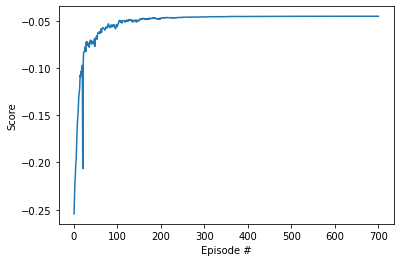

In [5]:
#Execute the cross entrophy method with default Values
#scores = cem()


#To don't ask the GPU as much reduce the pop_size, it's the amount of elemts try
scores,best_actions = cem_no_net()
# 
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
    

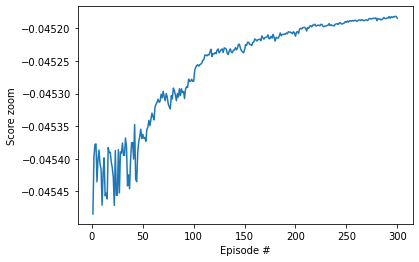

In [6]:

# plot the last scores zoom
fig = plt.figure()
zoom= 300
ax = fig.add_subplot(111)
plt.plot(np.arange(1, zoom+1), scores[-zoom:])
plt.ylabel('Score zoom')
plt.xlabel('Episode #')
plt.show()

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


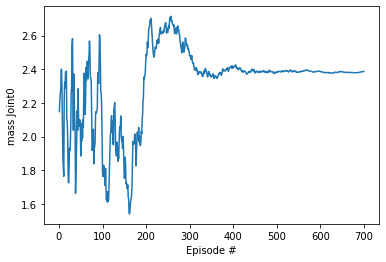

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


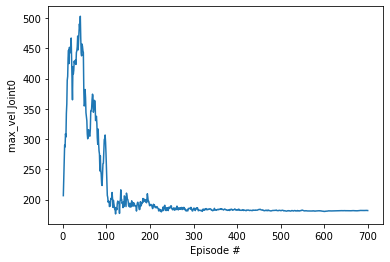

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


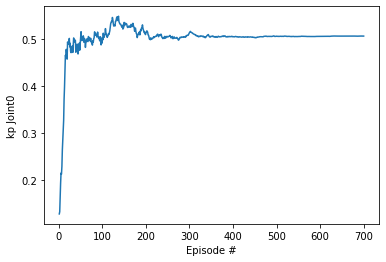

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


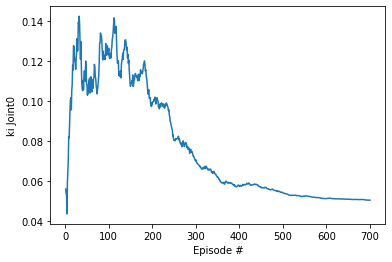

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


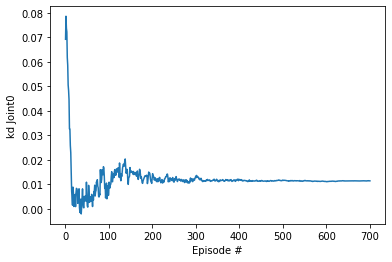

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


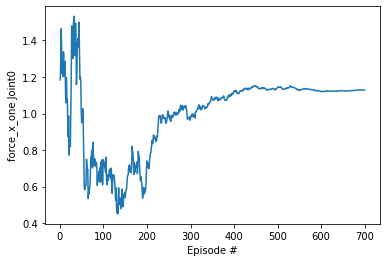

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


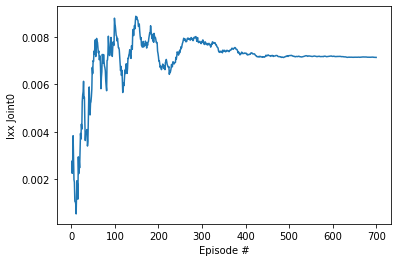

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


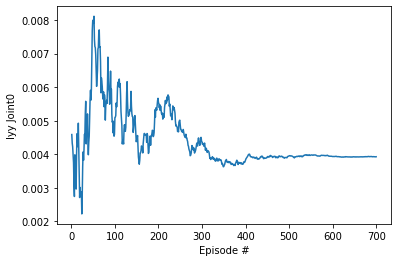

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


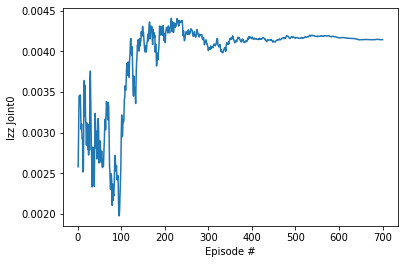

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


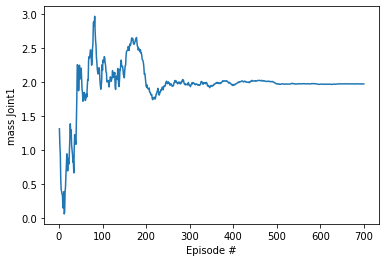

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


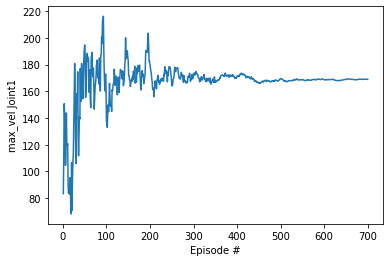

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


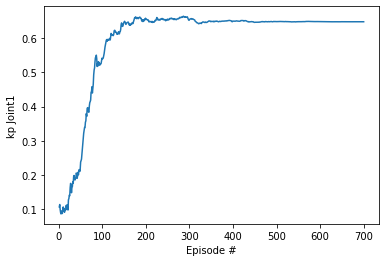

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


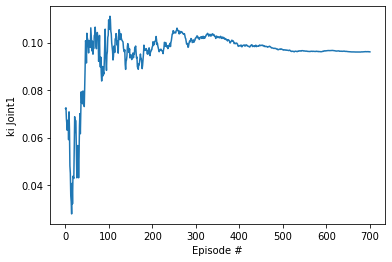

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


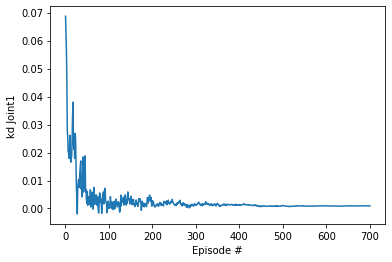

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


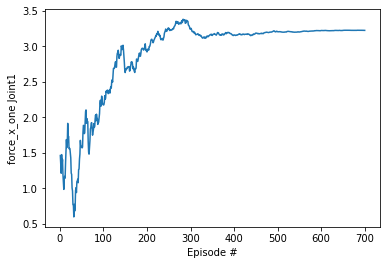

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


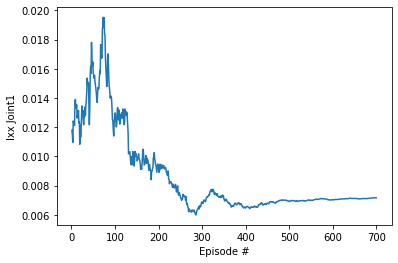

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


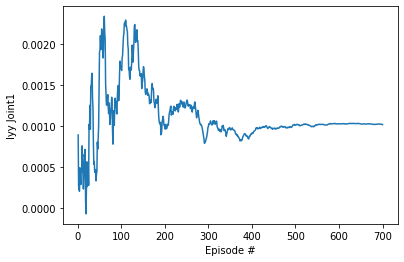

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


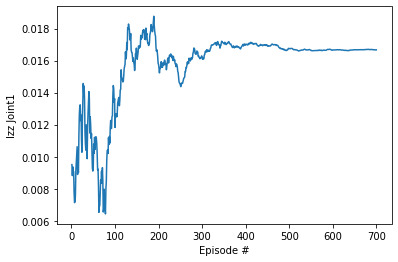

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


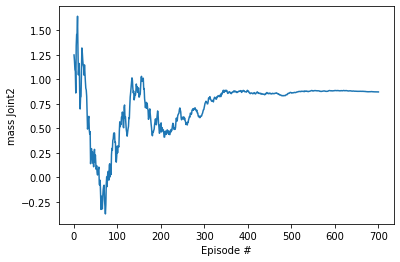

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


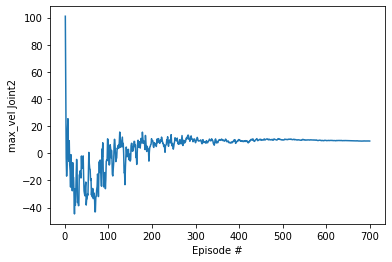

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


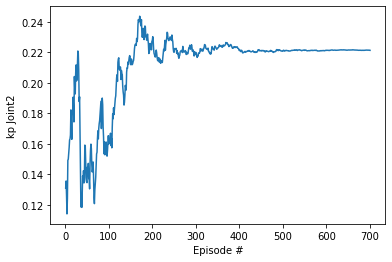

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


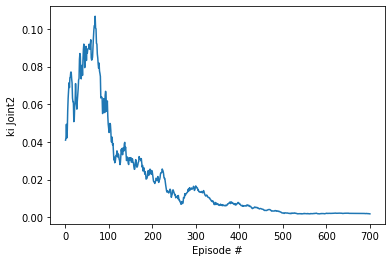

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


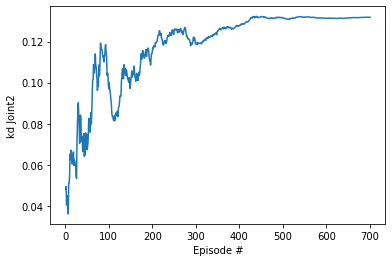

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


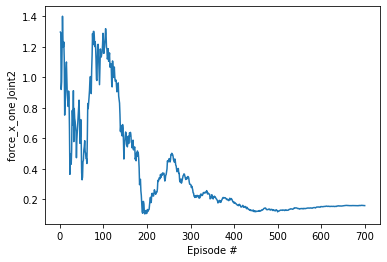

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


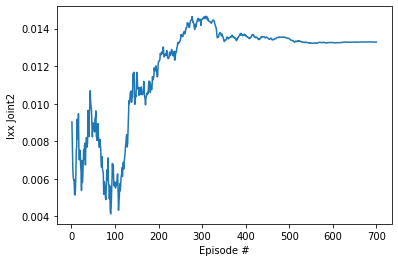

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


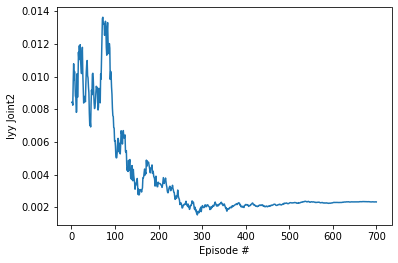

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


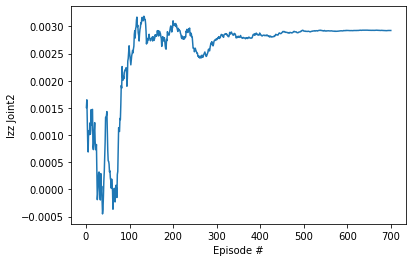

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


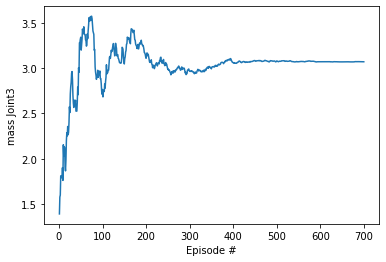

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


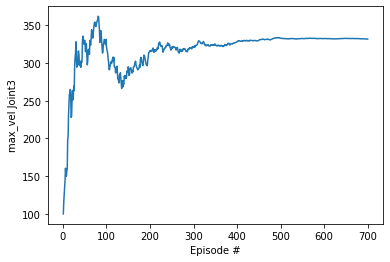

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


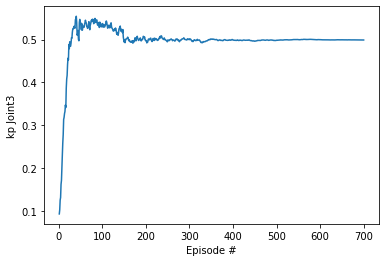

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


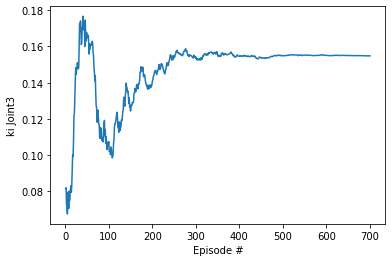

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


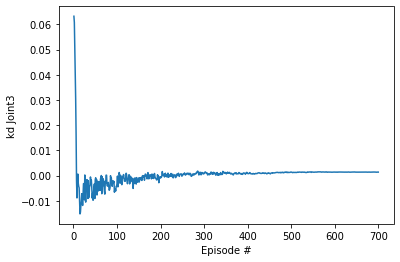

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


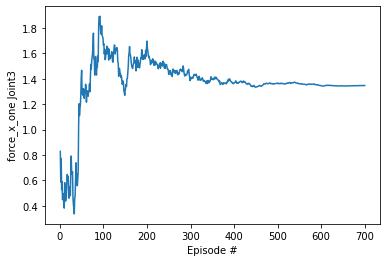

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


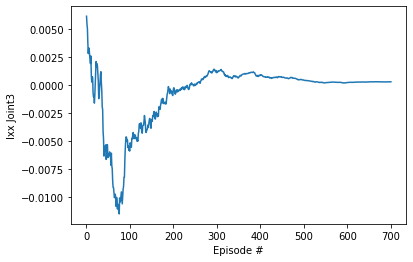

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


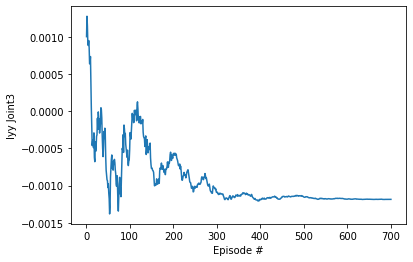

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


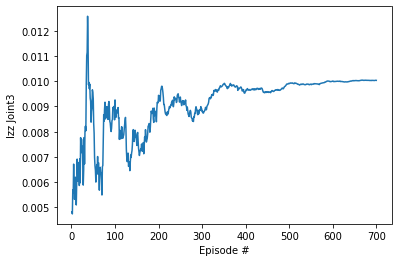

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


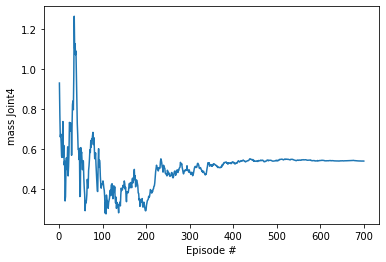

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


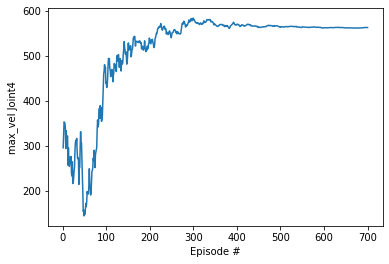

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


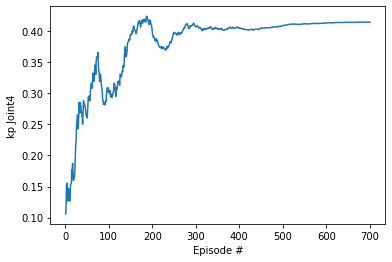

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


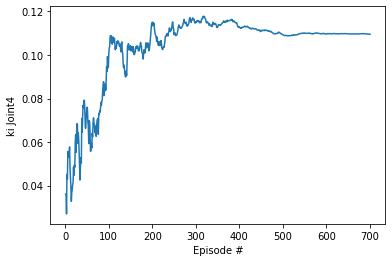

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


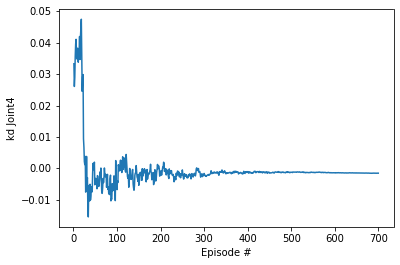

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


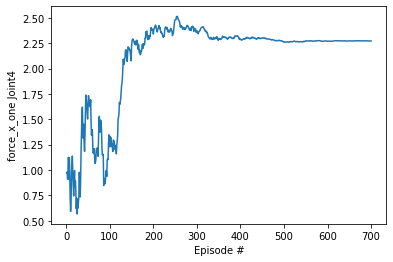

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


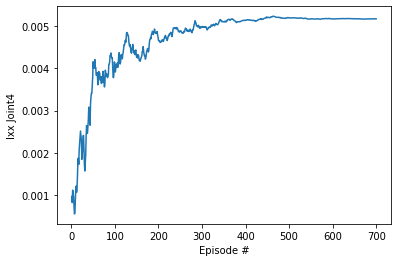

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


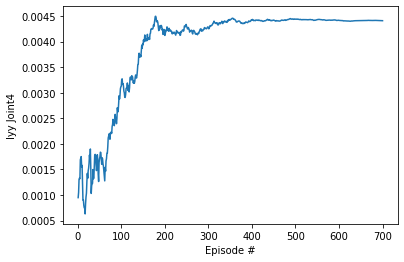

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


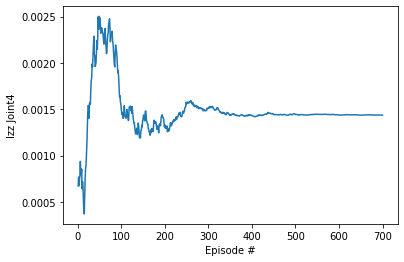

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


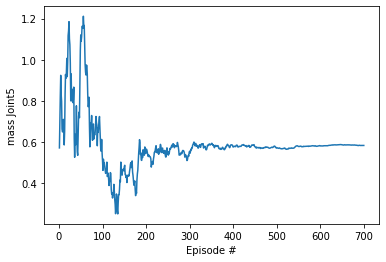

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


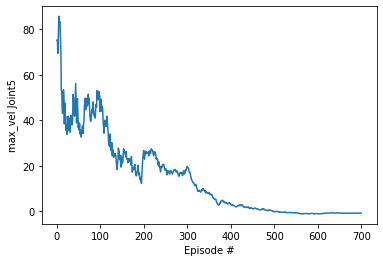

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


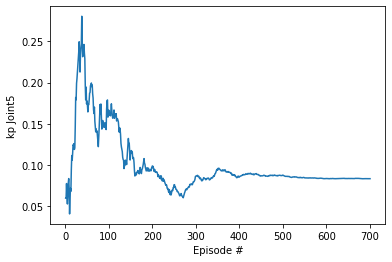

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


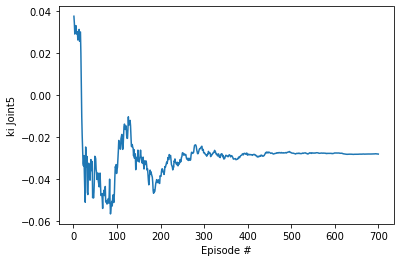

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


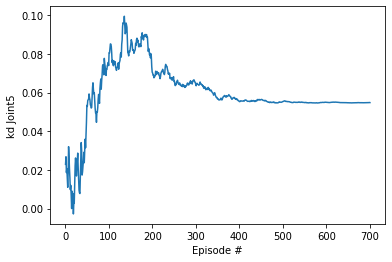

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


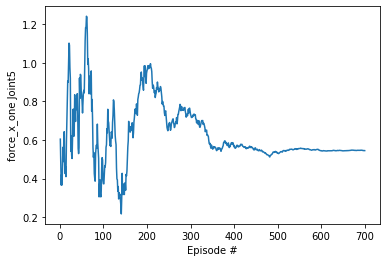

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


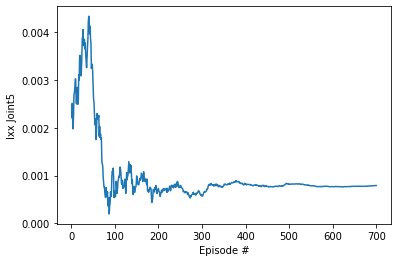

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


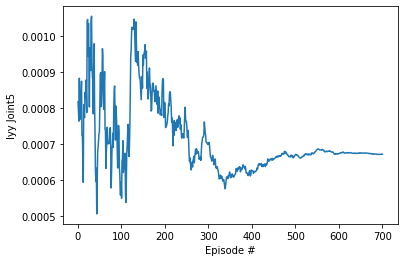

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


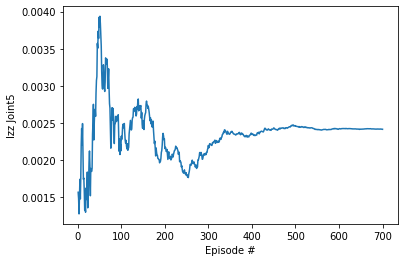

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


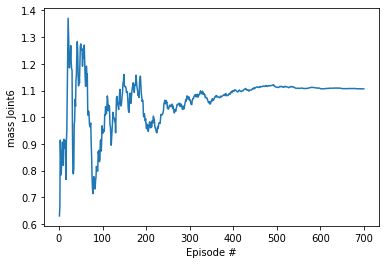

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


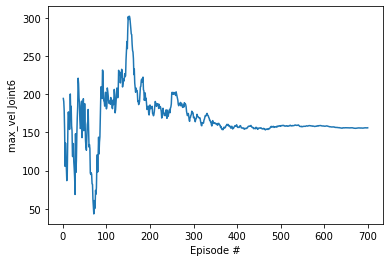

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


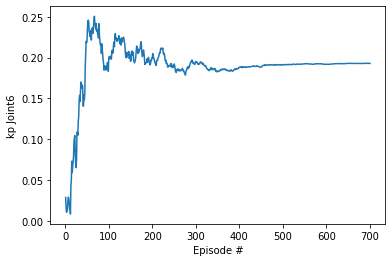

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


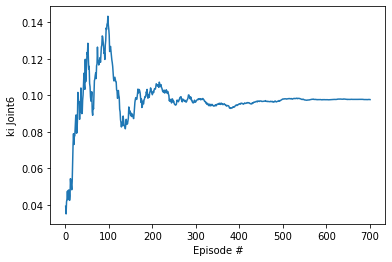

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


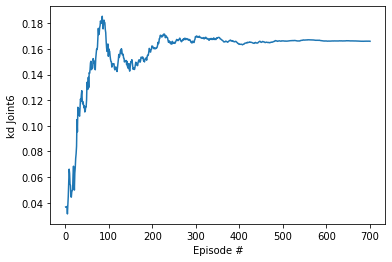

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


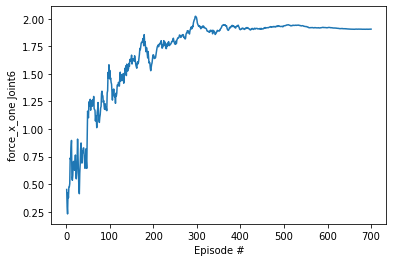

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


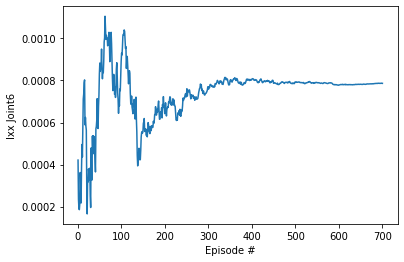

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


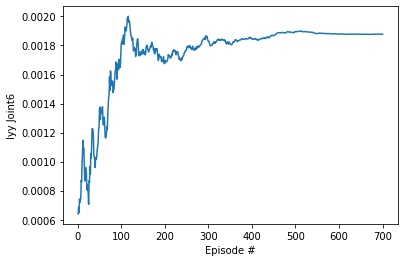

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


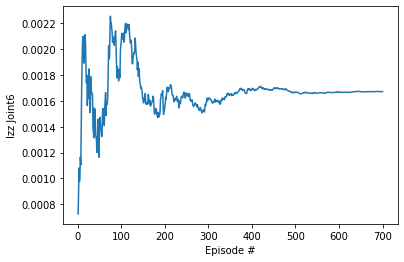

In [7]:
# plot actions
best_actions_np = np.array(best_actions)
for joint in range(7):
    for i in range(len(env.parameters_to_modify)) :
        parameter = env.parameters_to_modify[i]
        figures = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(1, best_actions_np.shape[0]+1), best_actions_np[:,joint+i*7])
        plt.ylabel(parameter+" Joint"+str(joint))
        plt.xlabel('Episode #')
        plt.show()

In [3]:
# load the weights from file
# Not working know


#state = env.reset()
env = env_pybullet_kin_gen3(no_zeros = True,Excels_path_Okay_tcp_list = ["Tcp_Trajectori_19_1.xlsx","Tcp_Trajectori_39_1.xlsx","Tcp_Trajectori_59_1.xlsx"],\
                            Actions_offsets_Numpy_files = ["acs_19_tcp.npy","acs_39_tcp.npy","acs_59_tcp.npy"],time_step=0.02,home_angles = [-0.207226464676801,1.5689993219813,-1.01515387451347,-2.45271819663908,2.00795352004673,1.91098991659003,-0.831045149646278])
env.robot.visual_inspection = True

#Make maxvels closer to the reality
env.max_vel = [168,151,128,94,210,48,189]
env.original_parameters_df ["max_vel"]=env.max_vel
env.modified_parameters_df ["max_vel"]=[168,151,128,94,210,48,189]

env.update_parameters_to_modify(["mass","max_vel","kp","ki","kd","force_x_one","Ixx","Iyy","Izz","damping"])
#env.update_parameters_to_modify_base(["mass_base","Ixx_base","Iyy_base","Izz_base"])
env.robot.visual_inspection = True
env.modified_parameters_df = env.create_df_from_Excel("./Parameters_train_tcp_euc_rishabh_joint_offset_base.xlsx")


t.sleep(0.02)
action = env.action_modified()
action = np.array(action)
print('original action:', env.action_original()) #parameters, number of parameters choose to tune, continuous
print("trained",action)
reward = env.step_tcp_rishabh_joints_offset(action,Experiment_time=1.22)
print("reward")
print(reward)



hola
../Simulation_Pybullet/models/urdf/JACO3_URDF_V11.urdf
Robot launched
hola
(7, 12)
(7, 17)
Base parameters mod    mass_base  Ixx_base  Iyy_base  Izz_base
0   1.697353  0.005787  0.005796  0.002735
Base parameters     mass_base  Ixx_base  Iyy_base  Izz_base
0   1.697353  0.005787  0.005796  0.002735
mass okey
max_vel okey
kp okey
ki okey
kd okey
force_x_one okey
Ixx okey
Iyy okey
Izz okey
damping okey
actions without base 7
actions without base 14
actions without base 21
actions without base 28
actions without base 35
actions without base 42
actions without base 49
actions without base 56
actions without base 63
actions without base 70
original action: [1.377353, 1.163667, 1.16366, 0.930287, 0.678106, 0.678106, 0.500657, 168, 151, 128, 94, 210, 48, 189, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 1, 1, 1, 1, 1, 1, 1, 0.00480078220558528, 0.008418724123621643, 0.007544516197001279, 0.0064096919604697605, 0.00

In [4]:
#Convert to excel
a = env.df_avg.to_numpy()
print(a[:,5])
env.df_avg.to_excel("./Train_parameters_result_tcp_euc_rishabh_joint_offset_base_19.xlsx")

[-0.009355    0.03149795  0.14596862  0.15541317  0.17796331  0.18211242
  0.21996065  0.30969988  0.36617057  0.40705811  0.37924968  0.43473582
  0.48127181  0.46502794  0.53382292  0.5133829   0.52033182  0.53652807
  0.64276569  0.73208134  0.75905185  0.78496492  0.84960525  0.93320501
  0.99592562  0.96422     0.94259678  0.91728427  0.91821884  0.97318452
  0.99386221  0.94905105  0.93371073  1.00547583  0.98079746  1.07242415
  1.14098939  1.10483726  1.18366468  1.24386344  1.21341232  1.20341731
  1.18122358  1.15528137  1.12659158  1.11032899  1.16516796  1.22921851
  1.24522997  1.29968383  1.25313261  1.29912669  1.33967229  1.28329408
  1.23704705  1.18805854  1.2418777   1.18917095  1.24450351  1.19649471
  1.24555688]


In [ ]:
env.original_parameters_df

In [ ]:
#Original ERROR
# load the weights from file
# Not working know


#state = env.reset()
env = env_pybullet_kin_gen3(no_zeros = True,Excels_path_Okay_tcp_list = ["Tcp_Trajectori_19_1.xlsx","Tcp_Trajectori_39_1.xlsx","Tcp_Trajectori_59_1.xlsx"],\
                            Actions_offsets_Numpy_files = ["acs_19_tcp.npy","acs_39_tcp.npy","acs_59_tcp.npy"],time_step=0.02,home_angles = [-0.207226464676801,1.5689993219813,-1.01515387451347,-2.45271819663908,2.00795352004673,1.91098991659003,-0.831045149646278])
#Make maxvels closer to the reality
env.max_vel = [168,151,128,94,210,48,189]
env.original_parameters_df ["max_vel"]=env.max_vel
env.modified_parameters_df ["max_vel"]=[168,151,128,94,210,48,189]

env.update_parameters_to_modify(["mass","max_vel","kp","ki","kd","force_x_one","Ixx","Iyy","Izz"])
#env.update_parameters_to_modify_base(["mass_base","Ixx_base","Iyy_base","Izz_base"])
env.robot.visual_inspection = True
env.modified_parameters_df = env.original_parameters_df


t.sleep(10)
action = env.action_modified()

action = np.array(action)
print(action)
reward = env.step_tcp_rishabh_joints_offset(action,Experiment_time=1.22)

print("reward")
print(reward)

In [ ]:
#Convert to excel
a = env.df_avg.to_numpy()
print(a[:,5])
env.df_avg.to_excel("./Original_parameters_result_tcp_euc_rishabh_joint_offset_59.xlsx")